# 一、用于预训练词嵌入的数据集

我们将以 14.1节的跳元模型和 14.2节的负采样为例。本节从用于预训练词嵌入模型的数据集开始：数据的原始格式将被转换为可以在训练期间迭代的小批量。

In [1]:
import math
import os
import random
import torch
from d2l import torch as d2l
from torch import nn

## 1.1 读取数据集

我们在这里使用的数据集是Penn Tree Bank（PTB）。该语料库取自“华尔街日报”的文章，分为训练集、验证集和测试集。在原始格式中，文本文件的每一行表示由空格分隔的一句话。在这里，我们将每个单词视为一个词元。

In [2]:
#@save
d2l.DATA_HUB['ptb'] = (d2l.DATA_URL + 'ptb.zip', '319d85e578af0cdc590547f26231e4e31cdf1e42')


#@save
def read_ptb():
    """将PTB数据集加载到文本行的列表中"""
    data_dir = d2l.download_extract('ptb')
    # 读取训练数据集
    with open(os.path.join(data_dir, 'ptb.train.txt')) as f:
        raw_text = f.read()
    return [line.split() for line in raw_text.split('\n')]


sentences = read_ptb()
f'# sentence数：{len(sentences)}'

'# sentence数：42069'

在读取训练集之后，我们为语料库构建了一个词表，其中出现次数少于10次的任何单词都将由“<unk>”词元替换。请注意，原始数据集还包含表示稀有（未知）单词的“<unk>”词元。

In [3]:
vocab = d2l.Vocab(sentences, min_freq=10)
f'vocab size: {len(vocab)}'

'vocab size: 6719'

## 1.2 下采样

文本数据通常有“the”“a”和“in”等高频词：它们在非常大的语料库中甚至可能出现数十亿次。然而，这些词经常在上下文窗口中与许多不同的词共同出现，提供的有用信息很少。例如，考虑上下文窗口中的词“chip”：直观地说，它与低频单词“intel”的共现比与高频单词“a”的共现在训练中更有用。此外，大量（高频）单词的训练速度很慢。因此，当训练词嵌入模型时，可以对高频单词进行下采样 (Mikolov et al., 2013)。具体地说，数据集中的每个词将有$w_i$概率地被丢弃

$$P\left(w_{i}\right)=\max \left(1-\sqrt{\frac{t}{f\left(w_{i}\right)}}, 0\right)$$

其中$f(w_i)$是$w_i$的词数与数据集中的总词数的比率，常量t是超参数（在实验中为$10^{-4}$）。我们可以看到，只有当相对比率$f(w_i)>t$时，（高频）词$w_i$才能被丢弃，且该词的相对比率越高，被丢弃的概率就越大。

In [4]:
#@save
def subsample(sentences, vocab):
    """下采样高频词"""
    # 排除未知词元<unk>
    sentences = [[token for token in line if vocab[token] != vocab.unk] for line in sentences]
    counter = d2l.count_corpus(sentences)  # 统计词元频次，封装成词元计数器
    num_tokens = sum(counter.values())  #获取词元总数

    # 计算P(wi),判断是否保留词元
    def keep(token):
        return (random.uniform(0, 1) < math.sqrt(1e-4 / counter[token] * num_tokens))

    return ([[token for token in line if keep(token)] for line in sentences], counter)


subsampled, counter = subsample(sentences, vocab)

下面的代码片段绘制了下采样前后每句话的词元数量的直方图。正如预期的那样，下采样通过删除高频词来显著缩短句子，这将使训练加速。

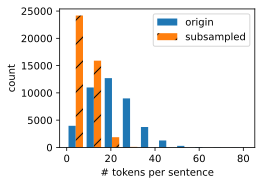

In [5]:
d2l.show_list_len_pair_hist(['origin', 'subsampled'], '# tokens per sentence', 'count', sentences, subsampled)

对于单个词元，高频词“the”的采样率不到1/20。

In [6]:
def compare_counts(token):
    return (f'"{token}"的数量：'
            f'之前={sum([l.count(token) for l in sentences])},'
            f'之后={sum([l.count(token) for l in subsampled])}')


compare_counts('the')

'"the"的数量：之前=50770,之后=2066'

相比之下，低频词“join”则被完全保留。

In [7]:
compare_counts('join')

'"join"的数量：之前=45,之后=45'

在下采样之后，我们将词元映射到它们在语料库中的索引。

In [8]:
corpus = [vocab[line] for line in subsampled]
corpus[:3]

[[], [71, 2115, 274], [140, 5277, 3054, 1580]]

In [9]:
count = 0
for line in subsampled:
    if count < 10:
        print(line)
        count += 1
    else:
        break

[]
['years', 'join', 'director']
['chairman', 'n.v.', 'dutch', 'publishing']
['former', 'consolidated', 'gold', 'fields', 'plc', 'was', 'named', 'director', 'british', 'industrial', 'conglomerate']
['a', 'form', 'asbestos', 'used', 'kent', 'cigarette', 'filters', 'caused', 'percentage', 'cancer', 'deaths', 'among', 'workers', 'exposed', 'more', 'researchers']
['asbestos', 'unusually', 'once', 'brief', 'causing', 'symptoms', 'show', 'decades', 'later', 'researchers']
['york-based', 'that', 'makes', 'kent', 'cigarettes', 'stopped', 'cigarette', 'filters', 'in']
['although', 'preliminary', 'findings', 'latest', 'appear', 'england', 'journal', 'medicine', 'bring', 'new', 'attention', 'problem']
['story']
['we', 'talking', 'before', 'anyone', 'heard', 'asbestos', 'having', 'questionable', 'properties']


In [10]:
len(vocab), len(counter), vocab['<unk>']

(6719, 6718, 0)

## 1.3 中心词和上下文词的提取

下面的get_centers_and_contexts函数从corpus中提取所有中心词及其上下文词。它随机采样1到max_window_size之间的整数作为上下文窗口。对于任一中心词，与其距离不超过采样上下文窗口大小的词为其上下文词。

In [11]:
#@save
def get_centers_and_contexts(corpus, max_window_size):
    """返回skip-gram模型中的中心词和上下文词"""
    centers, contexts = [], []
    for line in corpus:
        # 要形成“中心词-上下文词”对，每个句子至少需要有两个词
        if len(line) < 2:
            continue
        centers += line
        for i in range(len(line)):  #上下文窗口中间i
            window_size = random.randint(1, max_window_size)
            indices = list(range(max(0, i - window_size), min(len(line), i + 1 + window_size)))

            # 从上下文词中排除中心词
            indices.remove(i)
            contexts.append([line[idx] for idx in indices])
    return centers, contexts

接下来，我们创建一个人工数据集，分别包含7个和3个单词的两个句子。设置最大上下文窗口大小为2，并打印所有中心词及其上下文词。

In [12]:
tiny_dataset = [list(range(7)), list(range(7, 10))]
print('数据集', tiny_dataset)
for center, context in zip(*get_centers_and_contexts(tiny_dataset, 2)):
    print('中心词', center, '的上下文词是：', context)

数据集 [[0, 1, 2, 3, 4, 5, 6], [7, 8, 9]]
中心词 0 的上下文词是： [1, 2]
中心词 1 的上下文词是： [0, 2, 3]
中心词 2 的上下文词是： [1, 3]
中心词 3 的上下文词是： [1, 2, 4, 5]
中心词 4 的上下文词是： [3, 5]
中心词 5 的上下文词是： [3, 4, 6]
中心词 6 的上下文词是： [5]
中心词 7 的上下文词是： [8]
中心词 8 的上下文词是： [7, 9]
中心词 9 的上下文词是： [7, 8]


在PTB数据集上进行训练时，我们将最大上下文窗口大小设置为5。下面提取数据集中的所有中心词及其上下文词。

In [13]:
all_centers, all_contexts = get_centers_and_contexts(corpus, 5)
# 注意：每个上下文词与中心词均可两两配对，所以上下文词的总数即中心词-上下文词对的个数
f'# “中心词-上下文词对”的数量：{sum([len(contexts) for contexts in all_contexts])}'

'# “中心词-上下文词对”的数量：1500324'

In [14]:
print([(centers, contexts) for centers, contexts in zip(all_centers, all_contexts)][:10])

[(71, [2115, 274]), (2115, [71, 274]), (274, [71, 2115]), (140, [5277]), (5277, [140, 3054, 1580]), (3054, [140, 5277, 1580]), (1580, [140, 5277, 3054]), (336, [2467, 656]), (2467, [336, 656]), (656, [2467, 2157])]


## 1.4 负采样

我们使用负采样进行近似训练。为了根据预定义的分布对噪声词进行采样，我们定义以下RandomGenerator类，其中（可能未规范化的）采样分布通过变量sampling_weights传递。

In [15]:
#@save
class RandomGenerator:
    """根据n个采样权重在{1,...,n}中随机抽取"""

    def __init__(self, sampling_weights):
        #Exclude
        self.population = list(range(1, len(sampling_weights) + 1))
        self.sampling_weights = sampling_weights
        self.candidates = []
        self.i = 0

    def draw(self):
        if self.i == len(self.candidates):
            # 缓存k个随机采样结果
            # 在给定的总体中，按照指定的权重，从中随机选择10,000个个体，并将这些个体组成一个列表返回
            self.candidates = random.choices(self.population, self.sampling_weights, k=10000)
            self.i = 0
        self.i += 1
        return self.candidates[self.i - 1]

例如，我们可以在索引1、2和3中绘制10个随机变量X，采样概率为P（X= 1）=2/9，P（X=2）=3/9和P（X=3）=4/9，如下所示。

In [16]:
#@save
generator = RandomGenerator([2, 3, 4])
[generator.draw() for _ in range(10)]

[3, 1, 2, 3, 1, 3, 3, 2, 3, 2]

对于一对中心词和上下文词，我们随机抽取了K个（实验中为5个）噪声词。根据word2vec论文中的建议，将噪声词w的采样概率P（w）设置为其在字典中的相对频率，其幂为0.75（Mikolov et al.，2013）。

In [17]:
#@save
def get_negatives(all_contexts, vocab, counter, K):
    """返回负采样中的噪声词"""
    # 索引为1、2、...（索引0是词表中排除的未知标记）
    sampling_weights = [counter[vocab.to_tokens(i)] ** 0.75
                        for i in range(1, len(vocab))]
    all_negatives, generator = [], RandomGenerator(sampling_weights)
    for contexts in all_contexts:
        negatives = []
        while len(negatives) < len(contexts) * K:  # 当负样本上下文数量小于上下文词数量的0.75倍时
            neg = generator.draw()  # 生成噪声词
            # 噪声词不能是上下文词
            if neg not in contexts:
                negatives.append(neg)
        all_negatives.append(negatives)
    return all_negatives


all_negatives = get_negatives(all_contexts, vocab, counter, 5)

## 1.5 小批量加载训练实例

在提取所有中心词及其上下文词和采样噪声词后，将它们转换成小批量的样本，在训练过程中可以迭代加载。

在小批量中，ith个样本包括中心词及其ni个上下文词和mi个噪声词。由于上下文窗口大小不同，ni+mi对于不同的i是不同的。因此，对于每个样本，我们在contexts_negatives个变量中将其上下文词和噪声词连结起来，并填充零，直到连结长度达到maxi ni +mi（max_len）。为了在计算损失时排除填充，我们定义了掩码变量masks。在masks中的元素和contexts_negatives中的元素之间存在一-对应关系，其中masks中的0（否则为1）对应于contexts_negatives中的填充。

为了区分正反例，我们在contexts_negatives中通过一个labels变量将上下文词与噪声词分开。类似于masks，在labels中的元素和contexts_negatives中的元素之间也存在一-对应关系，其中labels中的1（否则为0）对应于contexts_negatives中的上下文词的正例。

上述思想在下面的batchify函数中实现。其输入data是长度等于批量大小的列表，其中每个元素是由中心词center、其上下文词context和其噪声词negative组成的样本。此函数返回一个可以在训练期间加载用于计算的小批量，例如包括掩码变量。

In [18]:
#@save
def batchify(data):
    """返回带有负采样的跳元模型的小批量样本"""
    # data：含有若干列表元素的元组
    max_len = max(len(c) + len(n) for _, c, n in data)
    centers, contexts_negatives, masks, labels = [], [], [], []
    for center, context, negative in data:
        cur_len = len(context) + len(negative)
        centers += [center]
        contexts_negatives += [context + negative + [0] * (max_len - cur_len)]
    masks += [[1] * cur_len + [0] * (max_len - cur_len)]
    labels += [[1] * len(context) + [0] * (max_len - len(context))]

    return (torch.tensor(centers).reshape((-1, 1)), torch.tensor(
        contexts_negatives), torch.tensor(masks), torch.tensor(labels))

让我们使用一个小批量的两个样本来测试此函数。

In [19]:
x_1 = (1, [2, 2], [3, 3, 3, 3])
x_2 = (1, [2, 2, 2], [3, 3])
batch = batchify((x_1, x_2))

names = ['centers', 'contexts_negatives', 'masks', 'labels']
for name, data in zip(names, batch):
    print(name, '=', data)

centers = tensor([[1],
        [1]])
contexts_negatives = tensor([[2, 2, 3, 3, 3, 3],
        [2, 2, 2, 3, 3, 0]])
masks = tensor([[1, 1, 1, 1, 1, 0]])
labels = tensor([[1, 1, 1, 0, 0, 0]])


## 1.6 整合代码

最后，我们定义了读取PTB数据集并返回数据迭代器和词表的load_data_ptb函数。

In [20]:
class PTBDataset(torch.utils.data.Dataset):
    def __init__(self, centers, contexts, negatives):
        assert len(centers) == len(contexts) == len(negatives)
        self.centers = centers
        self.contexts = contexts
        self.negatives = negatives

    def __getitem__(self, index):
        return (self.centers[index], self.contexts[index],
                self.negatives[index])

    def __len__(self):
        return len(self.centers)

In [21]:
#@save
def load_data_ptb(batch_size, max_window_size, num_noise_words):
    """下载PTB数据集，然后将其加载到内存中"""
    num_workers = 0  #工作线程数
    sentences = read_ptb()  #获取句子
    vocab = d2l.Vocab(sentences, min_freq=10)  #构建词表
    subsampled, counter = subsample(sentences, vocab)  #对高频词进行下采样，返回小草杨后的结果和计数器
    corpus = [vocab[line] for line in subsampled]  #根据下采样后的结果构建语料库
    all_centers, all_contexts = get_centers_and_contexts(  #获取语料库中的所有中心词和上下文词
        corpus, max_window_size)
    all_negatives = get_negatives(  #负采样，获取所有反例（以均衡正反例数量）
        all_contexts, vocab, counter, num_noise_words)

    dataset = PTBDataset(all_centers, all_contexts, all_negatives)  #基于所有中心词、上下文词和负采样词构建数据集

    data_iter = torch.utils.data.DataLoader(  # 加载该数据集并构建迭代器
        dataset, batch_size, shuffle=True,
        collate_fn=batchify, num_workers=num_workers)
    return data_iter, vocab  #返回迭代器，词表


让我们打印数据迭代器的第一个小批量。

In [22]:
data_iter, vocab = load_data_ptb(512, 5, 5)
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([1, 60])
labels shape: torch.Size([1, 60])


# 二、预训练word2vec

我们继续实现 14.1节中定义的跳元语法模型。然后，我们将在PTB数据集上使用负采样预训练word2vec。

In [23]:
batch_size, max_window_size, num_noise_words = 512, 5, 5
data_iter, vocab = d2l.load_data_ptb(batch_size, max_window_size, num_noise_words)

In [24]:
for batch in data_iter:
    for name, data in zip(names, batch):
        print(name, 'shape:', data.shape)
    break

centers shape: torch.Size([512, 1])
contexts_negatives shape: torch.Size([512, 60])
masks shape: torch.Size([512, 60])
labels shape: torch.Size([512, 60])


## 2.1 skip-gram模型

我们通过嵌入层和批量矩阵乘法实现了跳元模型。首先，让我们回顾一下嵌入层是如何工作的。

### 2.1.1 嵌入层

嵌入层将词元的索引映射到其特征向量。该层的权重是一个矩阵，其行数等于字典大小（input_dim）列数等于每个标记的向量维度（output_dim）。在词嵌入模型训练之后，这个权重就是我们所需要的。

In [25]:
embed = nn.Embedding(num_embeddings=20, embedding_dim=4)
print(embed.weight)
print(f'Parameter embedding_weight({embed.weight.shape},'
      f'dtype={embed.weight.dtype})')

Parameter containing:
tensor([[ 0.9540,  0.2334, -0.1252,  1.9277],
        [ 1.1793,  1.6551,  0.1143,  1.0665],
        [ 0.5633,  0.3490, -1.2059,  0.7725],
        [ 0.8498,  1.8995,  0.9653,  0.3027],
        [ 0.4959,  0.9098, -0.4238, -0.4992],
        [ 0.0143,  0.8358,  1.1537,  0.2231],
        [ 1.8979, -0.8094, -2.7011, -1.0765],
        [ 0.9569,  0.2363,  0.3821,  0.5239],
        [-2.0973,  0.4106, -1.0972,  0.7541],
        [ 0.8246,  1.7360,  1.2719,  1.7809],
        [-0.6486, -0.9340,  0.6406,  0.4858],
        [ 1.5828,  1.5111, -0.1233,  0.3507],
        [ 0.7013,  0.5971,  1.3500,  0.0296],
        [-0.4638, -0.5533,  0.5733,  0.8353],
        [-0.2362,  0.3431,  0.4684,  0.0600],
        [ 0.6206, -0.6840, -0.8767, -1.3148],
        [-1.2326,  1.9369, -0.0137, -0.1086],
        [ 1.1945,  0.7685, -0.9227,  0.7835],
        [-0.2476,  1.2922, -1.9930, -1.2179],
        [-1.3170,  0.6029, -0.5776, -1.0838]], requires_grad=True)
Parameter embedding_weight(torch.Size

嵌入层的输入是词元（词）的索引。对于任何词元索引i，其向量表示可以从嵌入层中的权重矩阵的第i行获得。由于向量维度（output_dim）被设置为4，因此当小批量词元索引的形状为（2，3）时，嵌入层返回具有形状（2，3，4）的向量。

In [26]:
x = torch.tensor([[1, 2, 3], [4, 5, 6]])
embed(x)

tensor([[[ 1.1793,  1.6551,  0.1143,  1.0665],
         [ 0.5633,  0.3490, -1.2059,  0.7725],
         [ 0.8498,  1.8995,  0.9653,  0.3027]],

        [[ 0.4959,  0.9098, -0.4238, -0.4992],
         [ 0.0143,  0.8358,  1.1537,  0.2231],
         [ 1.8979, -0.8094, -2.7011, -1.0765]]], grad_fn=<EmbeddingBackward0>)

### 2.1.2 定义前向传播

在前向传播中，skip-gram模型的输入包括形状为（批量大小，1）的中心词索引center和形状为（批量大小，max_len）的上下文与噪声词索引contexts_and_negatives，其中max_len在上一节被定义。这两个变量首先通过嵌入层从词元索引转换成向量，然后它们的批量矩阵相乘返回形状为（批量大小，1，max_len）的输出。输出中的每个元素是中心词向量和上下文向量或噪声词向量的点积。

In [27]:
def skip_gram(center, contexts_and_negatives, embed_v, embed_u):
    v = embed_v(center)
    u = embed_u(contexts_and_negatives)
    pred = torch.bmm(v, u.permute(0, 2, 1))
    return pred

让我们为一些样例输入打印此skip_gram函数的输出形状。

In [28]:
skip_gram(torch.ones((2, 1), dtype=torch.long),
          torch.ones((2, 4), dtype=torch.long), embed, embed).shape

torch.Size([2, 1, 4])

## 2.2 训练

在训练带负采样的跳元模型之前，我们先定义它的损失函数。

### 2.2.1 二元交叉熵损失

根据 14.2.1节中负采样损失函数的定义，我们将使用二元交叉熵损失。

In [29]:
class SigmoidBCELoss(nn.Module):
    """带掩码的二元交叉熵损失"""

    def __init__(self):
        super(SigmoidBCELoss, self).__init__()

    def forward(self, inputs, target, mask=None):
        out = nn.functional.binary_cross_entropy_with_logits(
            inputs, target, weight=mask, reduction="none")
        return out.mean(dim=1)


loss = SigmoidBCELoss()

nn.functional.binary_cross_entropy_with_logits()是PyTorch深度学习框架中的一个函数，它用于计算二分类问题中预测值和真实标签之间的损失。

在二分类任务中，模型的输出通常是一组逻辑回归（Logistic Regression）的得分或 logits，该函数的作用就是将 logits 转换为概率分布，并计算其与真实标签之间的二元交叉熵损失（Binary Cross Entropy Loss）。该函数的数学表达式为：

$$\text{loss}(x, y) = -\frac{1}{N}\sum_{i=1}^N [y_i \cdot \log(\sigma(x_i)) + (1 - y_i) \cdot \log(1 - \sigma(x_i))]$$

其中，$x$ 是模型的输出 logits，$y$ 是真实标签，$\sigma$ 是 sigmoid 函数。

这个函数有两个主要输入参数：`input` 和 `target`，分别表示模型的输出 logits 和真实标签。此外，还可以通过其他可选参数来设置权重、缩放因子等。具体用法和更多信息可以查看 PyTorch 官方文档。

函数的参数解释如下：

* inputs: 模型输出的预测张量，通常称为logits。它们是未经过sigmoid或softmax处理的原始模型输出，因此可以是任意实数值。

* target: 目标类别标签，必须是二进制的0或1。形状应与inputs相同。

* weight: 可选参数，用于对不同样本的权重进行加权。默认情况下，所有样本的权重都为1。可以通过传递一个形状与target相同的张量来指定不同的权重。例如，如果你希望让某些样本对损失产生更大的贡献，则可以将它们的权重设置为更高的值。

* reduction: 可选参数，用于控制如何计算损失的标量值。可以是以下字符串之一：

  * "none": 不进行任何缩减，返回每个样本的损失值。
  * "mean": 对每个样本的损失值取平均值，然后返回标量值。这是最常见的缩减方式。
  * "sum": 对每个样本的损失值求和，然后返回标量值。



回想一下我们在 14.3.5节中对掩码变量和标签变量的描述。下面计算给定变量的二进制交叉熵损失。

In [30]:
pred = torch.tensor([[1.1, -2.2, 3.3, -4.4]] * 2)
label = torch.tensor([[1.0, 0.0, 0.0, 0.0], [0.0, 1.0, 0.0, 0.0]])
mask = torch.tensor([[1, 1, 1, 1], [1, 1, 0, 0]])
loss(pred, label, mask) * mask.shape[1] / mask.sum(axis=1)

tensor([0.9352, 1.8462])

In [31]:
def sigmd(x):
    return -math.log(1 / (1 + math.exp(-x)))


# 这里正负号的问题没弄明白
# 盲猜是label为1意为预测正确，误差即为x，label为0则意为预测错误，误差为0-x，所以正负号会改变
print(f'{(sigmd(1.1) + sigmd(2.2) + sigmd(-3.3) + sigmd(4.4)) / 4:.4f}')
print(f'{(sigmd(-1.1) + sigmd(-2.2)) / 2:.4f}')

0.9352
1.8462


### 2.2.2 初始化模型参数

我们定义了两个嵌入层，将词表中的所有单词分别作为中心词和上下文词使用。字向量维度embed_size被设置为100。

In [32]:
embed_size = 100
net = nn.Sequential(  #定义一个包含两层嵌入层的序列
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
    nn.Embedding(num_embeddings=len(vocab), embedding_dim=embed_size),
)

### 2.2.3 定义训练阶段代码

训练阶段代码实现定义如下。由于填充的存在，损失函数的计算与以前的训练函数略有不同。

In [33]:
def train(net, data_iter, lr, num_epochs, device=d2l.try_gpu()):
    def init_weights(m):
        if type(m) == nn.Embedding:
            nn.init.xavier_uniform_(m.weight)  #初始化权重

    net.apply(init_weights)  #将权重应用于net模型中
    net = net.to(device)  #切换设备
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)  #定义优化器
    animator = d2l.Animator(xlabel='epoch', ylabel='loss', xlim=[1, num_epochs])  #动画绘图
    # 规范化的损失之和，规范化的损失数
    metric = d2l.Accumulator(2)  #创建一个容器，定义normalize后的loss值总和和计算loss的总数
    for epoch in range(num_epochs):  #对每一个训练周期
        timer, num_batches = d2l.Timer(), len(data_iter)  #计时，计数
        for i, batch in enumerate(data_iter):  #对每一个batch
            optimizer.zero_grad()  #梯度清零
            ## data_iter这个数据迭代器没看明白，点进去不知道为啥查看不了源码
            center, context_negative, mask, label = [data.to(device) for data in batch]  #解包
            pred = skip_gram(center, context_negative, net[0], net[1])  #skip_gram预测
            # print(f'pred.shape={pred.shape},label.shape={label.shape}')
            l = (loss(pred.reshape(label.shape).float(), label.float(), mask)
                 / mask.sum(axis=1) * mask.shape[1])  #计算loss并normalize
            l.sum().backward()  #反向传播
            optimizer.step()  #更新参数
            metric.add(l.sum(), l.numel())  #将loss值总和和loss个数存入metric容器
            if (i + 1) % (num_batches // 5) == 0 or i == num_batches - 1:  #隔5个epoch画个图
                animator.add(epoch + (i + 1) / num_batches, (metric[0] / metric[1],))
    print(f'loss {metric[0] / metric[1]:.3f}, '
          f'{metric[1] / timer.stop():.1f} tokens/sec on {str(device)}')

>nn.init.xavier_uniform_(m.weight)是PyTorch中的一个函数，用于对神经网络中的权重进行初始化。具体来说，它使用 Xavier 均匀分布来初始化权重。
Xavier 初始化是一种常用的权重初始化方法，旨在使输入和输出的方差相等。通过使输入和输出的方差相等，可以避免梯度消失或爆炸，从而改善训练效果。
xavier_uniform_() 是一种 Xavier 初始化方法之一，它随机生成均匀分布在 [-a, a] 之间的数值，其中 a = sqrt(6 / (n_in + n_out))，n_in 是输入层大小，n_out 是输出层大小。
因此，nn.init.xavier_uniform_(m.weight) 的意思就是将 m 这个神经网络层的权重按照 Xavier 均匀分布进行初始化。

现在，我们可以使用负采样来训练跳元模型。

loss 0.410, 90004.9 tokens/sec on cuda:0


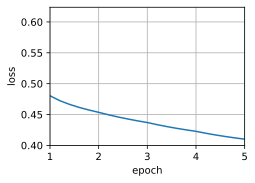

In [34]:
lr, num_epochs = 0.002, 5
train(net, data_iter, lr, num_epochs)

## 2.3 应用词嵌入

在训练word2vec模型之后，我们可以使用训练好模型中词向量的余弦相似度来从词表中找到与输入单词语义最相似的单词。

In [35]:
def get_similar_tokens(query_token, k, embed):
    W = embed.weight.data
    x = W[vocab[query_token]]
    #计算余弦相似性。增加1e-9以获得数值稳定性
    cos = torch.mv(W, x) / torch.sqrt(torch.sum(W * W, dim=1) *
                                      torch.sum(x * x) + 1e-9)
    topk = torch.topk(cos, k=k + 1)[1].cpu().numpy().astype('int32')  #获取相似性最高的k个值
    for i in topk[1:]:  #删除输入词
        print(f'cosine sim={float(cos[i]):.3f}：{vocab.to_tokens(i)}')


get_similar_tokens('chip', 3, net[0])

cosine sim=0.678：microprocessor
cosine sim=0.668：intel
cosine sim=0.599：innovative


> torch.mv是PyTorch中的一个函数，用于计算矩阵和向量之间的乘积。它采用两个输入，一个是二维矩阵（M*N维），另一个是一维张量（N维）。
具体地说，torch.mv函数将给定的向量视为列向量并与矩阵相乘，返回一个新的一维张量作为结果。例如，如果有一个大小为MxN的矩阵A和一个长度为N的向量b，则可以使用以下方式计算它们之间的乘积：
> ```
> result = torch.mv(A, b)  # result是一个长度为M的向量
> ```
> 该函数在深度学习中很常用，比如在前向传播中计算全连接层的输出，或在梯度下降算法中更新权重参数时计算梯度等。

>topk = torch.topk(cos,k=k+1)[1].cpu().numpy().astype('int32')
这是一个使用PyTorch库中的函数来获取给定张量中前k个最大值及其对应的索引的语句。
具体来说，torch.topk()函数接受两个参数: 第一个是需要查找最大值的输入张量（在本例中是cos），第二个是需要返回的最大值数量（在这里是 k+1，因为它将返回前k+1个最大值）。 返回值是一个元组，其中包含两个张量：第一个张量包含最大值，第二个张量包含相应最大值的索引。
由于上述代码还需要将结果转换为NumPy数组格式并进行类型强制转换，因此整个语句的作用是获取cos张量中前k+1个最大值的索引，并将它们存储在一个名为topk的整数数组中。

# 三、全局向量的词嵌入（GloVe）

上下文窗口内的词共现可以携带丰富的语义信息。例如，在一个大型语料库中，“固体”比“气体”更有可能与“冰”共现，但“气体”一词与“蒸汽”的共现频率可能比与“冰”的共现频率更高。此外，可以预先计算此类共现的全局语料库统计数据：这可以提高训练效率。为了利用整个语料库中的统计信息进行词嵌入，让我们首先回顾 14.1.3节中的跳元模型，但是使用全局语料库统计（如共现计数）来解释它。

## 3.1 带全局预料统计的skip_gram模型
用$q_ij$表示词$w_j$的条件概率$P(w_j|w_i)$,在skip_gram模型中给定词$w_i$,有:

$$l_{i j}=\frac{\operatorname{exp}(\mathbf{u}_{j}\mathbf{v}_{i})}{\sum_{k\in\mathcal{V}}\operatorname{exp}(\mathbf{u}_{k}^{\top}\mathbf{v}_{i})}$$

其中，对于任意索引i，向量v;和u,分别表示词0作为中心词和上下文词，且V = {0, 1,.….,|V-1}是词表的索引集d

考虑词;可能在语料库中出现多次。在整个语料库中，所有以w;为中心词的上下文词形成一个词索引的多吏集C;，该索引允许同一元素的多个买例。对于任何元素，其买例数称为其更数。举例说明，假设词;在语料库中出现两次，并且在两个上下文窗口中以w;为其中心词的上下文词索引是k,j, m,k和k,L,k, j。因此，多重集C；= {j, j,k,k,k,k,L, m}，其中元素j,k,L,m的重数分别为2、4、1、1。

现在，让我们将多重集$C_i$中的元素j的重数表示为$x_{ij}$。这是词$w_j$（作为上下文词）和词$w_i$（作为中心词）在整个语料库的同一上下文窗口中的全局共现计数。使用这样的全局语料库统计，跳元模型的损失函数等价于:

$$-\sum_{i\in\mathcal{V}}\sum_{j\in\mathcal{V}}x_{ij}\log q_{ij}$$

我们用$x_{i}$表示上下文窗口中的所有上下文词的数量，其中$w_i$作为它们的中心词出现，这相当于$|C_i|$。设$p_{ij}$为用于生成上下文词$w_j$的条件概率$x_{ij}/x_{i}$。给定中心词$w_i$，上式可以重写为:

$$-\sum_{i\in\mathcal{V}}x_i\sum_{j\in\mathcal{V}}p_{ij}\log q_{ij}$$

在(14.5.3)中，$-\sum_{j\in\mathcal{V}}p_{ij}\log q_{ij}$计算全局语料统计的条件分布$p_{ij}$和模型预测的条件分布$q_{ij}$的交叉熵。如上所述，这一损失也按$x_i$加权。在（14.5.3)中最小化损失函数将使预测的条件分布接近全局语料库统计中的条件分布。

虽然交叉熵损失函数通常用于测量概率分布之间的距离，但在这里可能不是一个好的选择。一方面，正如我们在 14.2节中提到的，规范化$q_{ij}$的代价在于整个词表的求和，这在计算上可能非常昂贵。另一方面，来自大型语料库的大量罕见事件往往被交叉熵损失建模，从而赋予过多的权重

## 3.2 GloVe模型

有鉴于此，GloVe模型基于平方损失 (Pennington et al., 2014)对跳元模型做了三个修改：

1. 使用变量$p'_{ij}=x_{ij}$和$q'_{ij}=\exp(\mathbf{u}_j^T\mathbf{v}_i)$而非概率分布，并取两者的对数。所以平方损失项是$\left(\log p_{i j}^{\prime}-\log q_{i j}^{\prime}\right)^{2}=\left(\mathbf{u}_{j}^{\top}\mathbf{v}_{i}-\log x_{i j}\right)^{\bullet}$。
2. 为每个词$w_i$添加两个标量模型参数:中心词偏置$b_i$和上下文偏置$c_i$.
3. 用权重函数$h(x_{ij})$替换每个损失项的权重,其中$h(x)$在[0,1]的间隔内递增.

整合代码，训练GloVe是为了尽量降低以下损失函数：

$$\sum\limits_{i\in\mathcal{V}}\sum\limits_{j\in\mathcal{V}}h(x_{ij})\big(\mathbf{u}_j^\top\mathbf{v}_i+b_i+c_j-\log x_{ij}\big)^2.$$

对于权重函数，建议的选择是：当x<c（例如，c=100）时，$h(x)=(x/c)^\alpha$（例如$\alpha=0.75$）,否则$h(x)=1$.在这种情况下，由于h(0)= 0，为了提高计算效率，可以省略任意$x_{ij}= 0$的平方损失项。例如，当使用小批量随机梯度下降进行训练时，在每次迭代中，我们随机抽样一小批量非零的xi来计算梯度并更新模型参数。注意，这些非零的x是预先计算的全局语料库统计数据；因此，该模型GloVe被称为全局向量。

应该强调的是，当词w；出现在词w，的上下文窗口时，词w；也出现在词w；的上下文窗口。因此，$x_{ij}=x_{ji}$与拟合非对称条件概率$p_{ij}$的word2vec不同，GloVe拟合对称概率$log x_{ij}$因此，在GloVe模型中，任意词的中心词向量和上下文词向量在数学上是等价的。但在实际应用中，由于初始值不同，同一个词经过训练后，在这两个向量中可能得到不同的值：Glove将它们相加作为输出向量。

## 3.3 从条件概率比值理解GloVe模型

我们也可以从另一个角度来理解GloVe模型。使用14.5.1节中的相同符号，设$p_{ij}\overset{\text{def}}{=}P(w_j\mid w_i)$为生成上下文词$w_j$的条件概率，给定$w_i$作为语料库中的中心词。14.5.3节根据大量语料库的统计数据，列出了给定单词"ice"和"steam"的共现概率及其比值。

![](https://files.mdnice.com/user/23981/791e49d1-81ab-4d0c-be16-fc9d6f046523.png)

Table: 大型语料库中的词-词共现概率及其比值（根据 (Pennington et al., 2014)中的表1改编）

从 14.5.3节中，我们可以观察到以下几点：

* 对于与"ice"相关但与"steam"无关的单词$w_k$，例如$w_k$ = solid，我们预计会有更大的共现概率比值，例如8.9。
* 对于与"steam"相关但与"ice"无关的单词$w_k$，例如$w_k$ = gas，我们预计较小的共现概率比值，例如0.085。
* 对于同时与"ice"和"steam"相关的单词$w_k$，例如$w_k$ = water，我们预计其共现概率的比值接近1，例如1.36.
* 对于与"ice"和"steam"都不相关的单词$w_k$，例如$w_k$ = fashion，我们预计共现概率的比值接近1，例如0.96.

由此可见，共现概率的比值能够直观地表达词与词之间的关系。因此，我们可以设计三个词向量的函数来拟合这个比值。对于共现概率$p_{ij}/p_{ik}$的比值，其中$w_i$是中心词，$w_j$和$w_k$是上下文词，我们希望使用某个函数f来拟合该比值：

$$f(\mathbf{u}_j,\mathbf{u}_k,\mathbf{v}_i)\approx\frac{p_{ij}}{p_{ik}}$$

在f的许多可能的设计中，我们只在以下几点中选择了一个合理的选择。因为共现概率的比值是标量，所以我们要求f是标量函数，例如$f(\mathbf{u}_j,\mathbf{u}_k,\mathbf{v}_i)=f\left(\left(\mathbf{u}_j-\mathbf{u}_k\right)^\top\mathbf{v}_i\right)$。在（14.5.5）中交换词索引j和k，它必须保持$f(x)f(-x)=1$，所以一种可能性是$f(x)=exp(x)$，即：

$$f(\mathbf{u}_j,\mathbf{u}_k,\mathbf{v}_i)=\frac{\exp\left(\mathbf{u}_j^\top\mathbf{v}_i\right)}{\exp\left(\mathbf{u}_k^\top\mathbf{v}_i\right)}\approx\frac{p_{ij}}{p_{ik}}$$

现在让我们选择$\exp\left(\mathbf{u}_j^{\top}\mathbf{v}_i\right)\approx\alpha p_{ij}$，其中a是常数。从$p_{ij}=x_{ij}/x_i$；开始，取两边的对数得到$\mathbf{u}_{j}^{i}\mathbf{v}_{i}\approx\log\alpha+\log x_{i j}-\log x_{i}$。我们可以使用附加的偏置项来拟合$-\log \alpha + \log x_i$，如中心词偏置$b_i$和上下文词偏置$c_j$：

$$\mathbf{u}_j^\top\mathbf{v}_i+b_i+c_j\approx\log x_{ij}$$

通过对 (14.5.7)的加权平方误差的度量，得到了 (14.5.4)的GloVe损失函数。

条件概率那个没太理解，感觉是损失函数越小，就能使得k和j的比值越趋向于1？？好奇怪

> 在使用GloVe损失函数进行训练时，你不需要显式地指定何时应该让共现概率比值"比较大"或"趋近1"。这是因为这些关系是从大规模语料库的统计数据中获得的，损失函数会根据这些数据来调整词向量，以最大程度地拟合这些共现关系。
训练过程中，模型会根据共现词对的统计信息进行梯度下降优化，使得损失函数逐步减小。通过不断迭代优化，模型会学习到词向量的表示，使得在内积运算中能够近似反映出我们期望的共现概率的对数差。
具体来说，当训练过程中的共现关系与期望的共现概率比值一致时，损失函数将得到较小的值。而当共现关系与期望的共现概率比值有差异时，损失函数将得到较大的值。通过最小化损失函数，模型会调整词向量的表示，使得模型能够更好地拟合观察到的共现关系。
因此，你不需要手动干预或指定何时应该使共现概率比值"比较大"或"趋近1"。训练过程会自动根据数据中的统计关系进行调整，并优化损失函数，使模型学习到适当的词向量表示。

# 四、子词嵌入

在英语中，“helps”“helped”和“helping”等单词都是同一个词“help”的变形形式。“dog”和“dogs”之间的关系与“cat”和“cats”之间的关系相同，“boy”和“boyfriend”之间的关系与“girl”和“girlfriend”之间的关系相同。在法语和西班牙语等其他语言中，许多动词有40多种变形形式，而在芬兰语中，名词最多可能有15种变形。在语言学中，形态学研究单词形成和词汇关系。但是，word2vec和GloVe都没有对词的内部结构进行探讨。

## 4.1 fastText模型
回想一下词在word2vec中是如何表示的。在跳元模型和连续词袋模型中，同一词的不同变形形式直接由不同的向量表示，不需要共享参数。为了使用形态信息，fastText模型提出了一种子词嵌入方法，其中子词是一个字符n-gram (Bojanowski et al., 2017)。fastText可以被认为是子词级跳元模型，而非学习词级向量表示，其中每个中心词由其子词级向量之和表示。

让我们来说明如何以单词“where”为例获得fastText中每个中心词的子词。首先，在词的开头和末尾添加特殊字符“<”和“>”，以将前缀和后缀与其他子词区分开来。 然后，从词中提取字符n-gram。 例如，值时，我们将获得长度为3的所有子词： “<wh”“whe”“her”“ere”“re>”和特殊子词“<where>”。

在fastText中，对于任意词w，用$\mathcal{G}_{w}$表示其长度在3和6之间的所有子词与其特殊子词的并集。词表是所有词的子词的集合。假设$z_g$是词典中的子词g的向量，则跳元模型中作为中心词的词w的向量$v_w$是其子词向量的和：

$$\mathbf{v}_w=\sum_{g\in\mathcal{G}_w}\mathbf{z}_g$$

fastText的其余部分与跳元模型相同。与跳元模型相比，fastText的词量更大，模型参数也更多。此外，为了计算一个词的表示，它的所有子词向量都必须求和，这导致了更高的计算复杂度。然而，由于具有相似结构的词之间共享来自子词的参数，罕见词甚至词表外的词在fastText中可能获得更好的向量表示。

## 4.2 字节对编码
在fastText中，所有提取的子词都必须是指定的长度，例如到

，因此词表大小不能预定义。为了在固定大小的词表中允许可变长度的子词，我们可以应用一种称为字节对编码（Byte Pair Encoding，BPE）的压缩算法来提取子词 (Sennrich et al., 2015)。

字节对编码执行训练数据集的统计分析，以发现单词内的公共符号，诸如任意长度的连续字符。从长度为1的符号开始，字节对编码迭代地合并最频繁的连续符号对以产生新的更长的符号。请注意，为提高效率，不考虑跨越单词边界的对。最后，我们可以使用像子词这样的符号来切分单词。字节对编码及其变体已经用于诸如GPT-2 (Radford et al., 2019)和RoBERTa (Liu et al., 2019)等自然语言处理预训练模型中的输入表示。在下面，我们将说明字节对编码是如何工作的。

首先，我们将符号词表初始化为所有英文小写字符、特殊的词尾符号'_'和特殊的未知符号'[UNK]'。

In [36]:
import collections

symbols = ['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm',
           'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z',
           '_', '[UNK]']

因为我们不考虑跨越词边界的符号对，所以我们只需要一个字典raw_token_freqs将词映射到数据集中的频率（出现次数）。注意，特殊符号'_'被附加到每个词的尾部，以便我们可以容易地从输出符号序列（例如，“a_all er_man”）恢复单词序列（例如，“a_all er_man”）。由于我们仅从单个字符和特殊符号的词开始合并处理，所以在每个词（词典token_freqs的键）内的每对连续字符之间插入空格。换句话说，空格是词中符号之间的分隔符。

In [37]:
raw_token_freqs = {'fast_': 4, 'faster_': 3, 'tall_': 5, 'taller_': 4}
token_freqs = {}
for token, freq in raw_token_freqs.items():
    token_freqs[' '.join(list(token))] = raw_token_freqs[token]
token_freqs

{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}

我们定义以下get_max_freq_pair函数,其返回词内最频繁的连续符号对,其中词来自输入词典token_freqs的键.

In [38]:
def get_max_freq_pair(token_freqs):
    pairs = collections.defaultdict(int)
    for token, freq in token_freqs.items():
        symbols = token.split()
        for i in range(len(symbols) - 1):
            # "pairs"的键是两个连续符号的元组
            pairs[symbols[i], symbols[i + 1]] += freq
    return max(pairs, key=pairs.get)  #具有最大值的pairs键

作为基于连续符号频率的贪心方法，字节对编码将使用以下merge_symbols函数来合并最频繁的连续符号对以产生新符号。

In [39]:
def merge_symbols(max_freq_pair, token_freqs, symbols):
    symbols.append(''.join(max_freq_pair))
    new_token_freqs = dict()
    for token, freq in token_freqs.items():
        new_token = token.replace(' '.join(max_freq_pair),
                                  ''.join(max_freq_pair))
        new_token_freqs[new_token] = token_freqs[token]
    return new_token_freqs

现在，我们对词典token_freqs的键迭代地执行字节对编码算法。在第一次迭代中，最频繁的连续符号对是't'和'a'，因此字节对编码将它们合并以产生新符号'ta'。在第二次迭代中，字节对编码继续合并'ta'和'l'以产生另一个新符号'tal'。

In [40]:
num_merges = 10
for i in range(num_merges):
    # token_freqs:{'f a s t _': 4, 'f a s t e r _': 3, 't a l l _': 5, 't a l l e r _': 4}
    max_freq_pair = get_max_freq_pair(token_freqs)
    token_freqs = merge_symbols(max_freq_pair, token_freqs, symbols)
    print(f'合并# {i + 1}:', max_freq_pair)

合并# 1: ('t', 'a')
合并# 2: ('ta', 'l')
合并# 3: ('tal', 'l')
合并# 4: ('f', 'a')
合并# 5: ('fa', 's')
合并# 6: ('fas', 't')
合并# 7: ('e', 'r')
合并# 8: ('er', '_')
合并# 9: ('tall', '_')
合并# 10: ('fast', '_')


在字节对编码的10次迭代之后，我们可以看到列表symbols现在又包含10个从其他符号迭代合并而来的符号。

In [41]:
print(symbols)

['a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z', '_', '[UNK]', 'ta', 'tal', 'tall', 'fa', 'fas', 'fast', 'er', 'er_', 'tall_', 'fast_']


对于在词典raw_token_freqs的键中指定的同一数据集，作为字节对编码算法的结果，数据集中的每个词现在被子词“fast_”“fast”“er_”“tall_”和“tall”分割。例如，单词“fast er_”和“tall er_”分别被分割为“fast er_”和“tall er_”。

In [42]:
print(list(token_freqs.keys()))

['fast_', 'fast er_', 'tall_', 'tall er_']


请注意，字节对编码的结果取决于正在使用的数据集。我们还可以使用从一个数据集学习的子词来切分另一个数据集的单词。作为一种贪心方法，下面的segment_BPE函数尝试将单词从输入参数symbols分成可能最长的子词。

In [43]:
def segment_BPE(tokens, symbols):
    outputs = []
    for token in tokens:
        start, end = 0, len(token)
        cur_output = []
        # 具有符号中可能最长子字的词元段
        while start < len(token) and start < end:
            if token[start: end] in symbols:
                cur_output.append(token[start: end])
                start = end
                end = len(token)
            else:
                end -= 1
        if start < len(token):
            cur_output.append('[UNK]')
        outputs.append(' '.join(cur_output))
    return outputs

我们使用列表symbols中的子词（从前面提到的数据集学习）来表示另一个数据集的tokens。

In [44]:
tokens = ['tallest_', 'fatter_']
print(segment_BPE(tokens, symbols))

['tall e s t _', 'fa t t er_']


BPE（Byte Pair Encoding）是一种常用的子词嵌入算法，用于将单词切分成更小的子词或子词单位。BPE算法是一种基于统计的无监督算法，广泛应用于自然语言处理任务中，如机器翻译、语言模型和命名实体识别等。

BPE算法的核心思想是通过迭代地合并出现频率最高的相邻字符或字符组合来构建子词词表。具体步骤如下：

1. 初始化：将每个字符作为初始子词，并统计所有子词的频率。
2. 计算频率：根据当前子词的频率统计，统计相邻子词的组合频率，如"he"和"llo"的组合频率为3。
3. 合并：选择出现频率最高的相邻子词组合，将其合并为一个新的子词，并更新词频表。
4. 更新：在新的词频表中重新计算相邻子词的组合频率，并重复步骤3，直到达到预设的子词数量或迭代次数。

通过多次迭代，BPE算法能够自动地将单词切分成更小的子词，其中频率高的子词会被保留，频率低的子词会被拆分成更小的子词。这样，BPE算法可以处理未登录词和复杂的词汇，同时也能够捕捉到单词内部的语义和形态信息。

在应用中，BPE算法通常用于预处理阶段，先构建一个子词词表，然后将文本数据中的单词根据词表进行切分，将其表示为子词序列。这样可以丰富单词的表示能力，提高模型在复杂词汇和未登录词上的泛化能力，同时减少词汇表的大小，降低模型的复杂性。

总而言之，BPE算法是一种基于统计的无监督子词嵌入算法，通过迭代地合并相邻字符或字符组合来构建子词词表，用于将单词切分成更小的子词或子词单位，以增强模型对复杂词汇和未登录词的处理能力。

# 五、词的相似性和类比任务

在 14.4节中，我们在一个小的数据集上训练了一个word2vec模型，并使用它为一个输入词寻找语义相似的词。实际上，在大型语料库上预先训练的词向量可以应用于下游的自然语言处理任务，这将在后面的 15节中讨论。为了直观地演示大型语料库中预训练词向量的语义，让我们将预训练词向量应用到词的相似性和类比任务中。

In [45]:
import os
import torch
from torch import nn
from d2l import torch as d2l

## 5.1 加载预训练词向量

以下列出维度为50、100和300的预训练GloVe嵌入，可从GloVe网站下载。预训练的fastText嵌入有多种语言。这里我们使用可以从fastText网站下载300维度的英文版本（“wiki.en”）。

In [46]:
#@save
d2l.DATA_HUB['glove.6b.50d'] = (d2l.DATA_URL + 'glove.6B.50d.zip',
                                '0b8703943ccdb6eb788e6f091b8946e82231bc4d')
#@save
d2l.DATA_HUB['glove.6b.100d'] = (d2l.DATA_URL + 'glove.6B.100d.zip',
                                 'cd43bfb07e44e6f27cbcc7bc9ae3d80284fdaf5a')
#@save
d2l.DATA_HUB['glove.42b.300d'] = (d2l.DATA_URL + 'glove.42B.300d.zip',
                                  'b5116e234e9eb9076672cfeabf5469f3eec904fa')
#@save
d2l.DATA_HUB['wiki.en'] = (d2l.DATA_URL + 'wiki.en.zip',
                           'c1816da3821ae9f43899be655002f6c723e91b88')

为了加载这些预训练的GloVe和fastText嵌入，我们定义了以下TokenEmbedding类。

In [47]:
#@save
class TokenEmbedding:
    """GloVe嵌入"""

    def __init__(self, embedding_name):
        self.idx_to_token, self.idx_to_vec = self._load_embedding(
            embedding_name)
        self.unknown_idx = 0
        self.token_to_idx = {token: idx for idx, token in
                             enumerate(self.idx_to_token)}

    def _load_embedding(self, embedding_name):
        idx_to_token, idx_to_vec = ['<unk>'], []
        data_dir = d2l.download_extract(embedding_name)
        # GloVe网站：https://nlp.stanford.edu/projects/glove/
        # fastText网站：https://fasttext.cc/
        with open(os.path.join(data_dir, 'vec.txt'), mode='r', encoding='utf-8') as f:
            for line in f:
                elems = line.rstrip().split(' ')
                token, elems = elems[0], [float(elem) for elem in elems[1:]]
                # 跳过标题信息，例如fastText中的首行
                if len(elems) > 1:
                    idx_to_token.append(token)
                    idx_to_vec.append(elems)
        idx_to_vec = [[0] * len(idx_to_vec[0])] + idx_to_vec
        return idx_to_token, torch.tensor(idx_to_vec)

    def __getitem__(self, tokens):
        indices = [self.token_to_idx.get(token, self.unknown_idx)
                   for token in tokens]
        vecs = self.idx_to_vec[torch.tensor(indices)]
        return vecs

    def __len__(self):
        return len(self.idx_to_token)

下面我们加载50维GloVe嵌入（在维基百科的子集上预训练）。创建TokenEmbedding实例时，如果尚未下载指定的嵌入文件，则必须下载该文件。

In [48]:
glove_6b50d = TokenEmbedding('glove.6b.50d')

输出词表大小。词表包含400000个词（词元）和一个特殊的未知词元。

In [49]:
len(glove_6b50d)

400001

In [50]:
glove_6b50d.token_to_idx['beautiful'], glove_6b50d.idx_to_token[3367]

(3367, 'beautiful')

## 5.2 应用预训练词向量

使用加载的GloVe向量，我们将通过下面的词相似性和类比任务中来展示词向量的语义。

### 5.2.1 词相似度
与 14.4.3节类似，为了根据词向量之间的余弦相似性为输入词查找语义相似的词，我们实现了以下knn（k近邻）函数。

In [51]:
def knn(W, x, k):
    # 增加1e-9以获得数值稳定性
    cos = torch.mv(W, x.reshape(-1, )) / (
            torch.sqrt(torch.sum(W * W, axis=1) + 1e-9) * torch.sqrt((x * x).sum()))
    _, topk = torch.topk(cos, k=k)
    return topk, [cos[int(i)] for i in topk]

>这个函数实现了K最近邻（K-Nearest Neighbors）算法。给定一个查询向量x，函数通过计算它与向量集合W中所有向量的余弦相似度来找到与x最相似的前k个向量。
具体步骤如下：
> 1. 计算余弦相似度：首先，函数计算查询向量x与向量集合W中每个向量之间的余弦相似度。这里使用了torch.mv函数，它执行矩阵-向量乘法，将W中的每个向量与x进行内积运算。为了数值稳定性，分母中添加了1e-9的小值以避免除以零的情况。
> 2. 选择最相似的k个向量：接下来，函数使用torch.topk函数找到余弦相似度最高的前k个向量。该函数返回两个值，第一个是最大值的索引，第二个是对应的最大值。在这里，我们只关注最大值的索引，因为我们需要返回最相似的向量的索引。
> 3. 返回结果：函数将最相似的k个向量的索引作为topk返回，并将它们对应的余弦相似度保存在列表中，作为额外的输出。

>总结起来，这个函数使用余弦相似度来计算查询向量x与向量集合W中每个向量的相似度，并返回最相似的k个向量的索引及其对应的相似度值。这个函数在信息检索、推荐系统等任务中常用于找到与给定查询最相似的数据点。

然后，我们使用TokenEmbedding的实例embed中预训练好的词向量来搜索相似的词。

In [52]:
def get_similar_tokens(query_token, k, embed):
    topk, cos = knn(embed.idx_to_vec, embed[[query_token]], k + 1)
    for i, c in zip(topk[1:], cos[1:]):  # 排除输入词
        print(f'{embed.idx_to_token[int(i)]}：cosine相似度={float(c):.3f}')

glove_6b50d中预训练词向量的词表包含400000个词和一个特殊的未知词元。排除输入词和未知词元后，我们在词表中找到与“chip”一词语义最相似的三个词。

In [53]:
get_similar_tokens('chip', 3, glove_6b50d)

chips：cosine相似度=0.856
intel：cosine相似度=0.749
electronics：cosine相似度=0.749


下面输出与“baby”和“beautiful”相似的词。

In [54]:
get_similar_tokens('baby', 3, glove_6b50d)

babies：cosine相似度=0.839
boy：cosine相似度=0.800
girl：cosine相似度=0.792


In [55]:
get_similar_tokens('beautiful', 3, glove_6b50d)

lovely：cosine相似度=0.921
gorgeous：cosine相似度=0.893
wonderful：cosine相似度=0.830


## 5.2.2 词类比

除了找到相似的词，我们还可以将词向量应用到词类比任务中。例如，"man"："woman"：："son"：
"daughter"是一个词的类比。"man"是对"woman"的类比，"son"是对"daughter"的类比。具体来说，词类比任务可以定义为：对于单词类比a:b:：c:d，给出前三个词a、b和c，找到d。用vec（w）表示词w的向量，为了完成这个类比，我们将找到一个词，其向量与vec（c）+ vec（b）- vec（a）的结果最相似。

In [56]:
def get_analogy(token_a, token_b, token_c, embed):
    vecs = embed[[token_a, token_b, token_c]]
    x = vecs[1] - vecs[0] + vecs[2]
    topk, cos = knn(embed.idx_to_vec, x, 1)
    return embed.idx_to_token[int(topk[0])]  # 删除未知词

让我们使用加载的词向量来验证“male-female”类比。

In [57]:
get_analogy('man', 'woman', 'son', glove_6b50d)

'daughter'

下面完成一个“首都-国家”的类比： “beijing” : “china” :: “tokyo” : “japan”。 这说明了预训练词向量中的语义。

In [58]:
get_analogy('beijing', 'china', 'tokyo', glove_6b50d)

'japan'

另外，对于“bad” : “worst” :: “big” : “biggest”等“形容词-形容词最高级”的比喻，预训练词向量可以捕捉到句法信息。

In [59]:
get_analogy('bad', 'worst', 'big', glove_6b50d)

'biggest'

为了演示在预训练词向量中捕捉到的过去式概念，我们可以使用“现在式-过去式”的类比来测试句法：“do” : “did” :: “go” : “went”。

In [60]:
get_analogy('do', 'did', 'go', glove_6b50d)

'went'

# 六、来自Transformers的双向编码器表示（BERT）

我们已经介绍了几种用于自然语言理解的词嵌入模型。在预训练之后，输出可以被认为是一个矩阵，其中每一行都是一个表示预定义词表中词的向量。事实上，这些词嵌入模型都是与上下文无关的。让我们先来说明这个性质。

## 6.1 从上下文无关到上下文敏感

回想一下14.4节和14.7节中的实验。例如，word2vec和Glove都将相同的预训练向量分配给同一个词，而不考虑词的上下文（如果有的话）。形式上，任何词元x的上下文无关表示是函数f(x)，其仅将x作为其输入。考虑到自然语言中丰富的多义现象和复杂的语义，上下文无关表示具有明显的局限性。例如，在"a crane is flying"（一只鹤在飞）和"a crane driver came"（一名吊车司机来了）的上下文中，"crane"一词有完全不同的含义；因此，同一个词可以根据上下文被赋予不同的表示。

这推动了“上下文敏感”词表示的发展。其中词的表征取决于它们的上下文。因此，词元x的上下文敏感表示是函数f(x,c(x))，其取决于x及其上下文c(x)。流行的上下文敏感表示包括TagLM（language-model-augmented sequence tagger，语言模型增强的序列标记器） (Peters et al., 2017)、CoVe（Context Vectors，上下文向量） (McCann et al., 2017)和ELMo（Embeddings from Language Models，来自语言模型的嵌入） (Peters et al., 2018)。

例如，通过将整个序列作为输入，ELMo是为输入序列中的每个单词分配一个表示的函数。具体来说，ELMo将来自预训练的双向长短期记忆网络的所有中间层表示组合为输出表示。然后，ELMo的表示将作为附加特征添加到下游任务的现有监督模型中，例如通过将ELMo的表示和现有模型中词元的原始表示（例如GloVe）连结起来。一方面，在加入ELMo表示后，冻结了预训练的双向LSTM模型中的所有权重。另一方面，现有的监督模型是专门为给定的任务定制的。利用当时不同任务的不同最佳模型，添加ELMo改进了六种自然语言处理任务的技术水平：情感分析、自然语言推断、语义角色标注、共指消解、命名实体识别和问答。

## 6.2 从特定于任务到不可知任务

尽管ELMo显著改进了各种自然语言处理任务的解决方案，但每个解决方案仍然依赖于一个特定于任务的架构。然而，为每一个自然语言处理任务设计一个特定的架构实际上并不是一件容易的事。GPT（Generative Pre Training，生成式预训练）模型为上下文的敏感表示设计了通用的任务无关模型 (Radford et al., 2018)。GPT建立在Transformer解码器的基础上，预训练了一个用于表示文本序列的语言模型。当将GPT应用于下游任务时，语言模型的输出将被送到一个附加的线性输出层，以预测任务的标签。与ELMo冻结预训练模型的参数不同，GPT在下游任务的监督学习过程中对预训练Transformer解码器中的所有参数进行微调。GPT在自然语言推断、问答、句子相似性和分类等12项任务上进行了评估，并在对模型架构进行最小更改的情况下改善了其中9项任务的最新水平。

然而，由于语言模型的自回归特性，GPT只能向前看（从左到右）。在“i went to the bank to deposit cash”（我去银行存现金）和“i went to the bank to sit down”（我去河岸边坐下）的上下文中，由于“bank”对其左边的上下文敏感，GPT将返回“bank”的相同表示，尽管它有不同的含义。

## 6.3 BERT：把两个最好的结合起来

如我们所见，ELMo对上下文进行双向编码，但使用特定于任务的架构；而GPT是任务无关的，但是从左到右编码上下文。BERT（来自Transformers的双向编码器表示）结合了这两个方面的优点。它对上下文进行双向编码，并且对于大多数的自然语言处理任务 (Devlin et al., 2018)只需要最少的架构改变。通过使用预训练的Transformer编码器，BERT能够基于其双向上下文表示任何词元。在下游任务的监督学习过程中，BERT在两个方面与GPT相似。首先，BERT表示将被输入到一个添加的输出层中，根据任务的性质对模型架构进行最小的更改，例如预测每个词元与预测整个序列。其次，对预训练Transformer编码器的所有参数进行微调，而额外的输出层将从头开始训练。 图14.8.1 描述了ELMo、GPT和BERT之间的差异。

![](https://files.mdnice.com/user/23981/e6749a29-7321-4307-93e8-968a4a1afb33.png)

BERT进一步改进了11种自然语言处理任务的技术水平，这些任务分为以下几个大类：（1）单一文本分类（如情感分析）、（2）文本对分类（如自然语言推断）、（3）问答、（4）文本标记（如命名实体识别）。从上下文敏感的ELMo到任务不可知的GPT和BERT，它们都是在2018年提出的。概念上简单但经验上强大的自然语言深度表示与训练已经cedilla改变了各种自然语言处理任务的解决方案。

在本章的其余部分，我们将深入了解BERT的训练前准备。当在 15节中解释自然语言处理应用时，我们将说明针对下游应用的BERT微调。

In [61]:
import torch
from torch import nn
from d2l import torch as d2l

## 6.4 输入表示

在自然语言处理中，有些任务（如情感分析）以单个文本作为收入，而有些任务（如自然语言推断）以一对文本序列作为输入。BERT输入序列明确地表示单个文本和文本对。当输入为单个文本时，BERT输入序列是“<cls>”、第一个文本序列的标记、“<sep>”、第二个文本序列标记、以及“<sep>”的连结。我们将始终如一地将术语“BERT输入序列”与其他类型的“序列”区分开来。例如，一个BERT输入序列可以包括一个文本序列或两个文本序列。

为了区分文本对，根据输入序列学到的片段嵌入$e_A$和$e_B$分别被添加到第一序列和第二序列的词元嵌入中。对于单文本输入，仅使用$e_A$。

下面的get_tokens_and_segments将一个句子或两个句子作为输入，然后返回BERT输入序列的标记及其相应的片段索引。

In [62]:
#@save
def get_tokens_and_segments(tokens_a, tokens_b=None):
    """获取输入序列的词元及其片段索引"""
    tokens = ['<cls>'] + tokens_a + ['<sep>']
    # 0和1分别标记片段A和B
    segments = [0] * (len(tokens_a) + 2)
    if tokens_b is not None:
        tokens += tokens_b + ['<sep>']
        segments += [1] * (len(tokens_b) + 1)
    return tokens, segments

BERT选择transformer编码器作为齐双向架构。在transformer编码器中常见的是，位置嵌入被加入到输入序列的每个位置。然而，与原始的transformer编码器不同，BERT使用科学系的位置嵌入。总之，BERT输入序列的嵌入是词元嵌入、片段嵌入和位置嵌入的和。

![](https://files.mdnice.com/user/23981/1d2e9f8b-6258-4353-9019-0e912f0dd7a5.png)

下面的BERTEncoder类类似于 10.7节中实现的TransformerEncoder类。与TransformerEncoder不同，BERTEncoder使用片段嵌入和可学习的位置嵌入。

In [63]:
#@save
class BERTEncoder(nn.Module):
    """BERT编码器"""

    def __init__(self, vocab_size, num_hiddens, norm_shape, ffn_num_input,
                 ffn_num_hiddens, num_heads, num_layers, dropout,
                 max_len=1000, key_size=768, query_size=768, value_size=768,
                 **kwargs):
        super(BERTEncoder, self).__init__(**kwargs)
        self.token_embedding = nn.Embedding(vocab_size, num_hiddens)  #词嵌入
        self.segment_embedding = nn.Embedding(2, num_hiddens)  #片段嵌入
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module(f"{i}", d2l.EncoderBlock(
                key_size, query_size, value_size, num_hiddens, norm_shape,
                ffn_num_input, ffn_num_hiddens, num_heads, dropout, True))
        # 在BERT中，位置嵌入是可学习的，因此我们创建一个足够长的位置嵌入参数
        self.pos_embedding = nn.Parameter(torch.randn(1, max_len,
                                                      num_hiddens))  #位置嵌入

    def forward(self, tokens, segments, valid_lens):
        # 在以下代码段中，X的形状保持不变：（批量大小，最大序列长度，num_hiddens）
        # X=词嵌入+片段嵌入+位置嵌入
        X = self.token_embedding(tokens) + self.segment_embedding(segments)
        X = X + self.pos_embedding.data[:, :X.shape[1], :]
        for blk in self.blks:
            X = blk(X, valid_lens)  #对每一个encoder block，都将X喂进去更新一下
        return X

假设词表大小为10000，为了演示BERTEncoder的前向推断，让我们创建一个实例并初始化它的参数。

In [64]:
vocab_size, num_hiddens, ffn_num_hiddens, num_heads = 10000, 768, 1024, 4
norm_shape, ffn_num_input, num_layers, dropout = [768], 768, 2, 0.2
encoder = BERTEncoder(vocab_size, num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                      num_heads, num_layers, dropout)

我们将tokens定义为长度为8的2个输入序列，其中每个词元是词表的索引。使用输入tokens的BERTEncoder的前向推断返回编码结果，其中每个词元由向量表示，其长度由超参数num_hiddens定义。此超参数通常称为Transformer编码器的隐藏大小（隐藏单元数）。

In [65]:
tokens = torch.randint(0, vocab_size, (2, 8))
segments = torch.tensor([[0, 0, 0, 0, 1, 1, 1, 1], [0, 0, 0, 1, 1, 1, 1, 1]])
encoded_X = encoder(tokens, segments, None)
encoded_X.shape

torch.Size([2, 8, 768])

## 6.5 预训练任务

BERTEncoder的前向推断给出了输入文本的每个词元和插入的特殊标记“<cls>”及“<seq>”的BERT表示。接下来，我们将使用这些表示来计算预训练BERT的损失函数。预训练包括以下两个任务：掩蔽语言模型和下一句预测。

### 6.5.1 掩蔽语言模型（Masked Language Modeling）

如 8.3节所示，语言模型使用左侧的上下文预测词元。为了双向编码上下文以表示每个词元，BERT随机掩蔽词元并使用来自双向上下文的词元以自监督的方式预测掩蔽词元。此任务称为掩蔽语言模型。

在这个预训练任务中，将随机选择15%的词元作为预测的掩蔽词元。要预测一个掩蔽词元而不使用标签作弊，一个简单的方法是总是用一个特殊的“<mask>”替换输入序列中的词元。然而，人造特殊词元“<mask>”不会出现在微调中。为了避免预训练和微调之间的这种不匹配，如果为预测而屏蔽词元（例如，在“this movie is great”中选择掩蔽和预测“great”），则在输入中将其替换为：

* 80%时间为特殊的“<mask>“词元（例如，“this movie is great”变为“this movie is<mask>”；

* 10%时间为随机词元（例如，“this movie is great”变为“this movie is drink”）；

* 10%时间内为不变的标签词元（例如，“this movie is great”变为“this movie is great”）。

请注意，在15%的时间中，有10%的时间插入了随机词元。这种偶然的噪声鼓励BERT在其双向上下文编码中不那么偏向于掩蔽词元（尤其是当标签词元保持不变时）。

我们实现了下面的MaskLM类来预测BERT预训练的掩蔽语言模型任务中的掩蔽标记。预测使用单隐藏层的多层感知机（self.mlp）。在前向推断中，它需要两个输入：BERTEncoder的编码结果和用于预测的词元位置。输出是这些位置的预测结果。

In [66]:
#@save
class MaskLM(nn.Module):
    """BERT的掩蔽语言模型任务"""
    def __init__(self,vocab_size,num_hiddens,num_inputs=768,**kwargs):
        super(MaskLM,self).__init__(**kwargs)
        self.mlp=nn.Sequential(nn.Linear(num_inputs,num_hiddens),   #全连接层
                               nn.ReLU(),   #激活函数
                               nn.LayerNorm(num_hiddens),   #层归一化
                               nn.Linear(num_hiddens,vocab_size))   #全连接层

    def forward(self,X,pred_positions):
        """
        :param X: 输入的嵌入表示
        :param pred_positions: 输入序列中掩蔽标记的位置
        :return:
        """
        num_pred_positions=pred_positions.shape[1]  # 获取掩蔽位置的数量
        pred_positions=pred_positions.reshape(-1)
        batch_size=X.shape[0]
        batch_idx=torch.arange(0,batch_size)    #创建一个张量batch_idx，表示批次中样本的索引，从0到batch_size-1
        # 假设batch_size=2，num_pred_positions=3
        # 那么batch_idx是np.array（[0,0,0,1,1,1]）
        batch_idx = torch.repeat_interleave(batch_idx, num_pred_positions)  #将batch_idx中的每个元素重复num_pred_positions次，这样就为每个批次维度创建了一个重要的批次索引
        masked_X = X[batch_idx, pred_positions] #使用batch_idx和pred_positions张量索引输入嵌入表示X，以收集掩蔽标记的嵌入表示，这选择了与掩蔽位置对应的嵌入表示
        masked_X = masked_X.reshape((batch_size, num_pred_positions, -1))
        mlm_Y_hat = self.mlp(masked_X)  #将掩蔽的嵌入表示 masked_X 通过 MaskLM 类中定义的 MLP（多层感知器）进行处理
        return mlm_Y_hat    #将预测的 MLM logits mlm_Y_hat 作为 forward 方法的输出返回

当 `X` 是一个形状为 `(2, 5, 3)` 的三维张量，表示两个样本的输入嵌入表示，每个样本有5个位置，每个位置的嵌入表示维度为3。假设 `batch_idx = [0, 0, 1, 1]`，`pred_positions = [1, 3, 2, 0]`。

则 `X[batch_idx, pred_positions]` 的结果如下：

```plaintext
X[0, 1] -> [0.1, 0.2, 0.3]
X[0, 3] -> [0.7, 0.8, 0.9]
X[1, 2] -> [1.2, 1.3, 1.4]
X[1, 0] -> [0.4, 0.5, 0.6]
```

这些结果被展平成一维张量，形状为 `(4, 3)`，即 `masked_X`。

所以，`masked_X` 包含了在指定掩蔽位置的嵌入表示，而 `X` 则包含了所有位置的嵌入表示。

为了演示MaskLM的前向推断，我们创建了其实例mlm并对其进行了初始化。回想一下，来自BERTEncoder的正向推断encoded_X表示2个BERT输入序列。我们将mlm_positions定义为在encoded_X的任一输入序列中预测的3个指示。mlm的前向推断返回encoded_X的所有掩蔽位置mlm_positions处的预测结果mlm_Y_hat。对于每个预测，结果的大小等于词表的大小.

In [67]:
mlm = MaskLM(vocab_size, num_hiddens)
mlm_positions = torch.tensor([[1, 5, 2], [6, 1, 5]])
mlm_Y_hat = mlm(encoded_X, mlm_positions)
mlm_Y_hat.shape

torch.Size([2, 3, 10000])

## 6.5.2 下一句预测（Next Sentence Prediction）

尽管掩蔽语言建模能够编码双向上下文来表示单词，但它不能显式地建模文本对之间的逻辑关系。为了帮助理解两个文本序列之间的关系，BERT在预训练中考虑了一个二元分类任务——下一句预测。在为预训练生成句子对时，有一半的时间它们确实是标签为“真”的连续句子；在另一半的时间里，第二个句子是从语料库中随机抽取的，标记为“假”。

下面的NextSentencePred类使用但隐藏层的多层感知机来预测第二个句子是否是BERT输入序列中第一给句子的下一个句子。由于transformer编码器中的自注意力，特殊词元"<cls>"的bert表示已经对输入的两个句子进行了编码。因此，多层感知机分类器的输出层（self.output）以X作为输入其中X是多层感知机隐藏层的输出，而MLP隐藏层的输入是编码后的"<cls>"词元。

In [68]:
#@save
class NextSentencePred(nn.Module):
    """BERT的下一句预测任务"""
    def __init__(self,num_inputs,**kwargs):
        super(NextSentencePred, self).__init__(**kwargs)
        self.output=nn.Linear(num_inputs,2)

    def forward(self, X):
        # X的形状：(batchsize,num_hiddens)
        return self.output(X)

我们可以看到，NextSentencePred实例的前向推断返回每个BERT输入序列的二分类预测。

In [69]:
encoded_X = torch.flatten(encoded_X, start_dim=1)
# NSP的输入形状:(batchsize，num_hiddens)
nsp = NextSentencePred(encoded_X.shape[-1])
nsp_Y_hat = nsp(encoded_X)
nsp_Y_hat.shape

torch.Size([2, 2])

In [70]:
print(encoded_X.shape)
print(nsp_Y_hat)

torch.Size([2, 6144])
tensor([[-0.8672,  0.4728],
        [-1.2461, -0.1042]], grad_fn=<AddmmBackward0>)


还可以计算两个二元分类的交叉熵损失。

In [74]:
nsp_y = torch.tensor([[0, 1],[1,1]])
nsp_l = loss(nsp_Y_hat, nsp_y)
nsp_l.shape

RuntimeError: result type Float can't be cast to the desired output type Long

值得注意的是，上述两个预训练任务中的所有标签都可以从预训练语料库中获得，而无需人工标注。原始的BERT已经在图书语料库 (Zhu et al., 2015)和英文维基百科的连接上进行了预训练。这两个文本语料库非常庞大：它们分别有8亿个单词和25亿个单词。

## 6.5.3 整合代码

在预训练BERT时，最终的损失函数是掩蔽语言模型损失函数和下一句预测损失函数的线性组合。现在我们可以通过实例化三个类BERTEncoder、MaskLM和NextSentencePred来定义BERTModel类。前向推断返回编码后的BERT表示encoded_X、掩蔽语言模型预测mlm_Y_hat和下一句预测nsp_Y_hat。

In [75]:
#@save
class BERTModel(nn.Module):
    """BERT模型"""
    def __init__(self,vocab_size,num_hiddens,norm_shape,ffn_num_input,
                 ffn_num_hiddens,num_heads,num_layers,dropout,
                 max_len=1000,key_size=768,query_size=768,value_size=768,
                 hid_in_features=768,mlm_in_features=768,nsp_in_features=768):
        """
        :param vocab_size: 词表大小
        :param num_hiddens: 隐藏层单元数
        :param norm_shape: 层归一化的形状
        :param ffn_num_input: 前馈神经网络的输入维度
        :param ffn_num_hiddens: 前馈神经网络的隐藏层数量
        :param num_heads: 注意力头数
        :param num_layers: 层数
        :param dropout: 丢弃率
        :param max_len: 输入序列的最大长度
        :param key_size: 注意力机制中的键的维度
        :param query_size: 注意力机制中的查询的维度
        :param value_size: 注意力机制中的值的维度
        :param hid_in_features: 用于隐藏层的输入特征维度
        :param mlm_in_features: 用于MaskLM任务的输入特征维度
        :param nsp_in_features: 用于NextSentencePred任务的输入特征维度
        """
        super(BERTModel, self).__init__()
        self.encoder=BERTEncoder(vocab_size,num_hiddens,norm_shape,
                                 ffn_num_input,ffn_num_hiddens,num_heads,num_layers,
                                 dropout,max_len=max_len,key_size=key_size,
                                 query_size=query_size,value_size=value_size)
        self.hidden=nn.Sequential(nn.Linear(hid_in_features,num_hiddens),
                                  nn.Tanh())
        self.mlm=MaskLM(vocab_size,num_hiddens,mlm_in_features)
        self.nsp=NextSentencePred(nsp_in_features)

    def forward(self,tokens,segments,valid_lens=None,pred_positions=None):
        """
        :param tokens: 标记序列
        :param segments: 分段序列
        :param valid_lens: 有效产度
        :param pred_positions: 掩码位置的索引
        :return: 编码后的嵌入向量，mlm的预测值，nsp的预测值
        """
        encoded_X=self.encoder(tokens,segments,valid_lens)  #编码后的嵌入向量
        if pred_positions is not None:
            mlm_Y_hat=self.mlm(encoded_X,pred_positions)
        else:
            mlm_Y_hat=None
        # 用于下一句预测的多层感知机分类器的隐藏层，0是”<cls>“标记的索引
        nsp_Y_hat=self.nsp(self.hidden(encoded_X[:,0,:]))
        return encoded_X,mlm_Y_hat,nsp_Y_hat

# 七、用于预训练BERT的数据集

为了预训练 14.8节中实现的BERT模型，我们需要以理想的格式生成数据集，以便于两个预训练任务：遮蔽语言模型和下一句预测。一方面，最初的BERT模型是在两个庞大的图书语料库和英语维基百科（参见 14.8.5节）的合集上预训练的，但它很难吸引这本书的大多数读者。另一方面，现成的预训练BERT模型可能不适合医学等特定领域的应用。因此，在定制的数据集上对BERT进行预训练变得越来越流行。为了方便BERT预训练的演示，我们使用了较小的语料库WikiText-2 (Merity et al., 2016)。

与 14.3节中用于预训练word2vec的PTB数据集相比，WikiText-2（1）保留了原来的标点符号，适合于下一句预测；（2）保留了原来的大小写和数字；（3）大了一倍以上。

In [76]:
import os
import random
import torch
from d2l import torch as d2l

在WikiText-2数据集中，每行代表一个段落，其中在任意标点符号及其前面的词元之间插入空格。保留至少有两句话的段落。为了简单起见，我们仅使用句号作为分隔符来拆分句子。我们将更复杂的句子拆分技术的讨论留在本节末尾的练习中。

In [77]:
#@save
d2l.DATA_HUB['wikitext-2'] = (
    'https://s3.amazonaws.com/research.metamind.io/wikitext/'
    'wikitext-2-v1.zip', '3c914d17d80b1459be871a5039ac23e752a53cbe')

#@save
def _read_wiki(data_dir):
    file_name = os.path.join(data_dir, 'wiki.train.tokens')
    with open(file_name, 'r',encoding='utf-8') as f:
        lines = f.readlines()
    # 大写字母转换为小写字母
    paragraphs = [line.strip().lower().split(' . ')
                  for line in lines if len(line.split(' . ')) >= 2]
    random.shuffle(paragraphs)
    return paragraphs

## 7.1 为预训练任务定义辅助函数

在下文中，我们首先为BERT的两个预训练任务实现辅助函数。这些辅助函数将在稍后将原始文本语料库转换为理想格式的数据集时调用，以预训练BERT。

### 7.1.1 生成下一句预测任务的数据

_get_next_sentence函数生成二分类任务的训练样本。

In [78]:
#@save
def _get_next_sentence(sentence,next_sentence,paragraphs):
    if random.random() <0.5:
        is_next=True
    else:
        # paragraphs是三重列表的嵌套
        next_sentence=random.choice(random.choice(paragraphs))
        is_next=False
    return sentence,next_sentence,is_next

下面的函数通过调用_get_next_sentence函数从输入paragraph生成用于下一句预测的训练样本。这里paragraph是句子列表，其中每个句子都是词元列表。自变量max_len指定与训练期间的bert输入序列的最大长度。

In [79]:
#@save
def _get_nsp_data_from_paragraph(paragraph,paragraphs,vocab,max_len):
    nsp_data_from_paragraph=[]
    for i in range(len(paragraph)-1):
        tokens_a,tokens_b,is_next=_get_next_sentence(paragraph[i],paragraph[i+1],paragraphs)
        # 考虑1个'<cls>'词元和2个'<seq>'词元
        if len(tokens_a)+len(tokens_b)+3>max_len:
            continue
        tokens,segments=d2l.get_tokens_and_segments(tokens_a,tokens_b)
        nsp_data_from_paragraph.append((tokens,segments,is_next))
    return nsp_data_from_paragraph

### 7.1.2 生成遮蔽语言模型任务的数据

为了从BERT输入序列生成遮蔽语言模型的训练样本，我们定义了以下_replace_mlm_tokens函数。在其输入中，tokens是表示BERT输入序列的词元的列表，candidate_pred_positions是不包括特殊词元的BERT输入序列的词元索引的列表（特殊词元在遮蔽语言模型任务中不被预测），以及num_mlm_preds指示预测的数量（选择15%要预测的随机词元）。在 14.8.5.1节中定义遮蔽语言模型任务之后，在每个预测位置，输入可以由特殊的“掩码”词元或随机词元替换，或者保持不变。最后，该函数返回可能替换后的输入词元、发生预测的词元索引和这些预测的标签。

In [80]:
#@save
def _replace_mlm_tokens(tokens,candidate_pred_positions,num_mlm_preds,vocab):
    """
    :param tokens: 输入的词元列表
    :param candidate_pred_positions: 候选的预测位置列表
    :param num_mlm_preds: 指定要预测的掩蔽语言模型的数量
    :param vocab: 词汇表，用于获取随机词元
    :return: 掩蔽后的输入词元列表，预测位置和对应词元的元组的列表
    """
    # 为掩蔽语言模型的输入拆功能键新的词元副本，其中输入可能包含替换的"<mask>"或随机词元
    mlm_input_tokens=[token for token in tokens]# 初始化为token的副本，用于存储替换后的输入
    pred_positions_and_labels=[]    #用于存储预测位置和对应原始词元的元组
    # 打乱后用于在遮蔽语言模型任务中获取15%的随机词元并进行预测
    random.shuffle(candidate_pred_positions)
    for mlm_pred_position in candidate_pred_positions:
        if len(pred_positions_and_labels) >= num_mlm_preds:
            break
        masked_token=None
        # 80%：将词替换为mask词元
        if random.random()<0.8:
            masked_token='<mask>'
        else:
            # 10%：保持词不变
            if random.random()<0.5:
                masked_token=tokens[mlm_pred_position]
            # 10%：用随机词替换该词
            else:
                masked_token=random.choice(vocab.idx_to_token)
            mlm_input_tokens[mlm_pred_position] = masked_token
            # 将预测位置和对应的原始词元的元组添加到pred_positions_and_labels中
            pred_positions_and_labels.append(
                (mlm_pred_position,tokens[mlm_pred_position])
            )
        return mlm_input_tokens,pred_positions_and_labels

通过调用前述的_replace_mlm_tokens函数，以下函数将BERT输入序列（tokens）作为输入，并返回输入词元的索引（在 14.8.5.1节中描述的可能的词元替换之后）、发生预测的词元索引以及这些预测的标签索引。

预测词元的数量（通常为输入词元总数的一定比例，如15%）是为了确定每个样本中需要遮蔽和预测的词元数量。这样做的目的是让模型在训练过程中有机会学习处理遮蔽词元的任务，以提高对上下文的理解能力和生成能力。

In [81]:
#@save
def _get_mlm_data_from_tokens(tokens,vocab):
    """
    :param tokens: 输入的词元列表
    :param vocab: 词汇表，用于转换词元为索引
    :return: 输入词元索引，预测的词元索引，预测的标签索引
    """
    candidate_pred_positions=[] #用于存储候选的预测位置，即不包含特殊词元'<cls>'和'<sep>'的位置
    #tokens是一个字符串列表
    # 遍历词元列表，如果词元是特殊词元，则跳过，否则将其位置添加到candidate_pred_positions中
    for i,token in enumerate(tokens):
        # 在掩蔽语言模型模型任务中不会预测特殊词元
        if token in ['<cls>','<sep>']:
            continue
        candidate_pred_positions.append(i)
    # 计算掩蔽语言模型任务中需要预测的词元数量，为输入词元总数的15%
    num_mlm_preds=max(1,round(len(tokens)*0.15))
    # 调用_replace_mlm_tokens函数（输入词元列表，候选预测位置列表，预测词元的数量，词汇表）
    # 返回（替换后的词元列表，预测位置即对应原始词元的列表
    mlm_input_tokens,pred_positions_and_labels=_replace_mlm_tokens(
        tokens,candidate_pred_positions,num_mlm_preds,vocab
    )
    pred_positions_and_labels=sorted(pred_positions_and_labels,key=lambda x:x[0])#按照预测位置的顺序进行排序
    # 从排序后的pred_positions_and_labels中提取预测位置列表pred_positions和原始词元列表mlm_pred_labels
    pred_positions=[v[0] for v in pred_positions_and_labels]
    mlm_pred_labels=[v[1] for v in pred_positions_and_labels]
    return vocab[mlm_input_tokens],pred_positions,vocab[mlm_pred_labels]

### 7.1.2 将文本转换为预训练数据集

现在我们几乎准备好为BERT预训练定制一个Dataset类。在此之前，我们仍然需要定义辅助函数_pad_bert_inputs来将特殊的“<mask>”词元附加到输入。它的参数examples包含来自两个预训练任务的辅助函数_get_nsp_data_from_paragraph和_get_mlm_data_from_tokens的输出。

In [82]:
#@save
def _pad_bert_inputs(examples, max_len, vocab):
    # 对输入样本进行填充，以便它们具有相同的长度，以便批量处理
    max_num_mlm_preds = round(max_len * 0.15)   #计算每个样本中需要预测的掩蔽语言模型词元数量的最大值
    # 初始化存储所有输入的列表：all_token_ids用于存储词元的索引，all_segments用于存储分段信息，valid_lens用于存储有效长度（不包括填充的'<pad>'），all_pred_positions用于存储预测位置的索引，all_mlm_weights用于存储掩蔽语言模型的权重，all_mlm_labels用于存储掩蔽语言模型的标签，nsp_labels用于存储下一句预测的标签
    all_token_ids, all_segments, valid_lens,  = [], [], []
    all_pred_positions, all_mlm_weights, all_mlm_labels = [], [], []
    nsp_labels = []
    # 对于每个样本，将其词元索引、预测位置、掩蔽语言模型标签、分段信息和下一句预测标签添加到对应的列表中。在填充时，将使用特殊的'<pad>'词元进行填充，使所有样本具有相同的长度
    for (token_ids, pred_positions, mlm_pred_label_ids, segments,
         is_next) in examples:
        all_token_ids.append(torch.tensor(token_ids + [vocab['<pad>']] * (
            max_len - len(token_ids)), dtype=torch.long))
        all_segments.append(torch.tensor(segments + [0] * (
            max_len - len(segments)), dtype=torch.long))
        # valid_lens不包括'<pad>'的计数
        valid_lens.append(torch.tensor(len(token_ids), dtype=torch.float32))
        all_pred_positions.append(torch.tensor(pred_positions + [0] * (
            max_num_mlm_preds - len(pred_positions)), dtype=torch.long))
        # 填充词元的预测将通过乘以0权重在损失中过滤掉
        all_mlm_weights.append(
            torch.tensor([1.0] * len(mlm_pred_label_ids) + [0.0] * (
                max_num_mlm_preds - len(pred_positions)),
                dtype=torch.float32))
        all_mlm_labels.append(torch.tensor(mlm_pred_label_ids + [0] * (
            max_num_mlm_preds - len(mlm_pred_label_ids)), dtype=torch.long))
        nsp_labels.append(torch.tensor(is_next, dtype=torch.long))
    return (all_token_ids, all_segments, valid_lens, all_pred_positions,
            all_mlm_weights, all_mlm_labels, nsp_labels)

将用于生成两个预训练任务的训练样本的辅助函数和用于填充输入的辅助函数放在一起，我们定义以下_WikiTextDataset类为用于预训练BERT的WikiText-2数据集。通过实现__getitem__函数，我们可以任意访问WikiText-2语料库的一对句子生成的预训练样本（遮蔽语言模型和下一句预测）样本。

最初的BERT模型使用词表大小为30000的WordPiece嵌入 (Wu et al., 2016)。WordPiece的词元化方法是对 14.6.2节中原有的字节对编码算法稍作修改。为简单起见，我们使用d2l.tokenize函数进行词元化。出现次数少于5次的不频繁词元将被过滤掉。

In [83]:
#@save
class _WikiTextDataset(torch.utils.data.Dataset):
    def __init__(self, paragraphs, max_len):
        # 输入paragraphs[i]是代表段落的句子字符串列表；
        # 而输出paragraphs[i]是代表段落的句子列表，其中每个句子都是词元列表
        paragraphs = [d2l.tokenize(
            paragraph, token='word') for paragraph in paragraphs]
        sentences = [sentence for paragraph in paragraphs
                     for sentence in paragraph]
        self.vocab = d2l.Vocab(sentences, min_freq=5, reserved_tokens=[
            '<pad>', '<mask>', '<cls>', '<sep>'])
        # 获取下一句子预测任务的数据
        examples = []
        for paragraph in paragraphs:
            examples.extend(_get_nsp_data_from_paragraph(
                paragraph, paragraphs, self.vocab, max_len))
        # 获取遮蔽语言模型任务的数据
        examples = [(_get_mlm_data_from_tokens(tokens, self.vocab)
                      + (segments, is_next))
                     for tokens, segments, is_next in examples]
        # 填充输入
        (self.all_token_ids, self.all_segments, self.valid_lens,
         self.all_pred_positions, self.all_mlm_weights,
         self.all_mlm_labels, self.nsp_labels) = _pad_bert_inputs(
            examples, max_len, self.vocab)

    def __getitem__(self, idx):
        return (self.all_token_ids[idx], self.all_segments[idx],
                self.valid_lens[idx], self.all_pred_positions[idx],
                self.all_mlm_weights[idx], self.all_mlm_labels[idx],
                self.nsp_labels[idx])

    def __len__(self):
        return len(self.all_token_ids)

通过使用_read_wiki函数和_WikiTextDataset类，我们定义了下面的load_data_wiki来下载并生成WikiText-2数据集，并从中生成预训练样本。

In [84]:
#@save
def load_data_wiki(batch_size, max_len):
    """加载WikiText-2数据集"""
    num_workers = d2l.get_dataloader_workers()
    data_dir = d2l.download_extract('wikitext-2', 'wikitext-2')
    paragraphs = _read_wiki(data_dir)
    train_set = _WikiTextDataset(paragraphs, max_len)
    train_iter = torch.utils.data.DataLoader(train_set, batch_size,
                                        shuffle=True, num_workers=num_workers)
    return train_iter, train_set.vocab


将批量大小设置为512，将BERT输入序列的最大长度设置为64，我们打印出小批量的BERT预训练样本的形状。注意，在每个BERT输入序列中，为遮蔽语言模型任务预测10（64 × 0.15）个位置。

In [ ]:
batch_size, max_len = 512, 64
train_iter, vocab = load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

最后，我们来看一下词量。即使在过滤掉不频繁的词元之后，它仍然比PTB数据集的大两倍以上。

In [ ]:
len(vocab)

# 八、预训练BERT

利用 14.8节中实现的BERT模型和 14.9节中从WikiText-2数据集生成的预训练样本，我们将在本节中在WikiText-2数据集上对BERT进行预训练。

In [1]:
import torch
from torch import nn
from d2l import torch as d2l

首先，我们加载WikiText-2数据集作为小批量的预训练样本，用于遮蔽语言模型和下一句预测。批量大小是512，BERT输入序列的最大长度是64。注意，在原始BERT模型中，最大长度是512。

In [2]:
batch_size, max_len = 512, 64
train_iter, vocab = d2l.load_data_wiki(batch_size, max_len)

for (tokens_X, segments_X, valid_lens_x, pred_positions_X, mlm_weights_X,
     mlm_Y, nsp_y) in train_iter:
    print(tokens_X.shape, segments_X.shape, valid_lens_x.shape,
          pred_positions_X.shape, mlm_weights_X.shape, mlm_Y.shape,
          nsp_y.shape)
    break

torch.Size([512, 64]) torch.Size([512, 64]) torch.Size([512]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512, 10]) torch.Size([512])


## 8.1 预训练Bert

原始模型有两个不同模型尺寸的版本。基本模型Bert-base使用12层（transformer编码器块），768个隐藏单元（隐藏大小）和12个注意力头。大模型Bert-large使用24层，1024个隐藏单元和16个注意力头。值得注意的是，前者有1.1亿个参数，后者有2.4亿给参数。为了便于演示，我们定义了一个小的Bert层，使用了2层、128个隐藏单元和2个自注意力头。

In [3]:
net=d2l.BERTModel(len(vocab),num_hiddens=128,norm_shape=[128],
                ffn_num_input=128,ffn_num_hiddens=256,num_heads=2,
                num_layers=2,dropout=0.2,key_size=128,query_size=128,
                value_size=128,hid_in_features=128,mlm_in_features=128,
                nsp_in_features=128)
devices=d2l.try_all_gpus()
loss=nn.CrossEntropyLoss()

在定义训练代码之前，我们定义了一个辅助函数_get_batch_loss_bert。给定训练样本，该函数极度那掩蔽语言模型和下一句子预测任务的损失。请注意，Bert与训练的最终损失是掩蔽语言模型损失和下一句预测损失之和。

In [4]:
#@save
def _get_batch_loss_bert(net,loss,vocab_size,tokens_X,segments_X,valid_lens_x,
                         pred_positions_X,mlm_weights_X,mlm_Y,nsp_y):
    #前向传播
    _,mlm_Y_hat,nsp_Y_hat=net(tokens_X,segments_X,valid_lens_x.reshape(-1),pred_positions_X)
    # 计算掩蔽语言模型损失
    mlm_l=loss(mlm_Y_hat.reshape(-1,vocab_size),mlm_Y.reshape(-1))*mlm_weights_X.reshape(-1,1)
    mlm_l=mlm_l.sum()/(mlm_weights_X.sum()+1e-8)
    # 计算下一句预测模型损失
    nsp_l=loss(mlm_Y_hat,nsp_y)
    l=mlm_l+nsp_l
    return mlm_l,nsp_l,l

通过调用上述两个辅助函数，下面的train_bert函数定义了在Wikitext-2（train_iter）数据集上与训练Bert（net）的过程。训练Bert可能需要很长时间。以下函数的输入num_steps指定了训练的迭代步数，而不是像train_ch13函数那样指定训练的轮数

In [5]:
def train_bert(train_iter,net,loss,vocab_size,devices,num_steps):
    #将模型放到指定设备上，并使用DataParallel模块进行并行化处理
    net = nn.DataParallel(net,device_ids=devices).to(devices[0])
    trainer=torch.optim.Adam(net.parameters(),lr=0.01)  #优化器用于更新模型参数，学习率设置为0.01
    step,timer=0,d2l.Timer()    #初始化步数step和计时器timer
    # 创建一个动画实例，用于存储掩蔽语言模型损失的和、下一句预测任务损失的和、句子对的数量和计数
    animator=d2l.Animator(xlabel='step',ylabel='loss',xlim=[1,num_steps],legend=['mlm','nsp'])
    # 定义一个容器，用于存储：掩蔽语言模型损失的和，下一句预测任务损失的和，句子对的数量，计数
    metric=d2l.Animator(4)
    num_steps_reached=False #设置一个标志变量，用于判断是否达到指定的训练步数
    while step<num_steps and not num_steps_reached:
        for tokens_X,segments_X,valid_lens_x,pred_positions_X,mlm_weights_X,mlm_Y,nsp_y in train_iter:  #在每个训练迭代中，从训练数据迭代器中获取输入数据
            # 将输入数据移动到指定的设备上
            tokens_X = tokens_X.to(devices[0])
            segments_X = segments_X.to(devices[0])
            valid_lens_x = valid_lens_x.to(devices[0])
            pred_positions_X = pred_positions_X.to(devices[0])
            mlm_weights_X = mlm_weights_X.to(devices[0])
            mlm_Y, nsp_y = mlm_Y.to(devices[0]), nsp_y.to(devices[0])
            trainer.zero_grad() #梯度清零
            timer.start()   #启动计时器
            # 计算批量训练的损失值
            mlm_l,nsp_l,l=_get_batch_loss_bert(
                net,loss,vocab_size,tokens_X,segments_X,valid_lens_x,
                pred_positions_X,mlm_weights_X,mlm_Y,nsp_y)
            l.backward()    #反向传播
            trainer.step()  #更新参数
            metric.add(mlm_l,nsp_l,tokens_X.shape[0],1) #更新metric实例的统计数据
            timer.stop()    #停止计时器
            animator.add(step+1,(metric[0]/metric[3],metric[1]/metric[3]))  #将损失值添加到animator实例中进行可视化
            step+=1 #增加步数
            if step==num_steps: #判断是否达到指定的训练步数，达到则跳出循环
                num_steps_reached=True
                break
    # 打印掩蔽语言模型损失和下一句预测任务损失的平均值
    print(f'MLM loss {metric[0] / metric[3]:.3f}, '
          f'NSP loss {metric[1] / metric[3]:.3f}')
    # 打印每秒处理的句子对数量和所使用的设备
    print(f'{metric[2] / timer.sum():.1f} sentence pairs/sec on '
          f'{str(devices)}')

#### nn.DataParallel

`nn.DataParallel`模块的作用是将模型并行化处理，以加速训练过程。在深度学习中，模型的训练通常需要大量的计算资源，包括GPU的计算能力。`nn.DataParallel`模块可以自动将模型的计算过程划分为多个子模型，并在多个GPU上并行执行，从而加快训练速度。

具体地，`nn.DataParallel`会将模型复制到每个可用的GPU上，并将输入数据分割成多个小批量，分别发送到不同的GPU上进行计算。每个GPU独立计算损失函数和梯度，并将梯度进行聚合后进行参数更新。这样，多个GPU可以同时进行计算，充分利用了多个GPU的计算能力，提高了训练的效率。

使用`nn.DataParallel`模块非常简单，只需将模型包裹在`nn.DataParallel`中，并指定要使用的GPU设备。然后，在训练过程中，输入数据会自动分发到各个GPU上，并行计算。

在预训练过程中，我们可以绘制出遮蔽语言模型损失和下一句预测损失

OutOfMemoryError: CUDA out of memory. Tried to allocate 396.00 MiB (GPU 0; 2.00 GiB total capacity; 1.23 GiB already allocated; 0 bytes free; 1.25 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

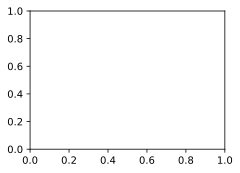

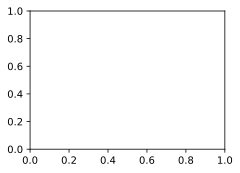

In [6]:
train_bert(train_iter, net, loss, len(vocab), devices, 50)

## 8.2 用Bert表示文本

在预训练Bert之后，我们可以用它来表示单个文本、文本对或其中的任何词元。下面的函数返回tokens_a和tokens_b中所有词元的Bert（net）表示。

In [ ]:
def get_bert_encoding(net, tokens_a, tokens_b=None):
    tokens, segments = d2l.get_tokens_and_segments(tokens_a, tokens_b)
    token_ids = torch.tensor(vocab[tokens], device=devices[0]).unsqueeze(0)
    segments = torch.tensor(segments, device=devices[0]).unsqueeze(0)
    valid_len = torch.tensor(len(tokens), device=devices[0]).unsqueeze(0)
    encoded_X, _, _ = net(token_ids, segments, valid_len)
    return encoded_X

考虑“a crane is flying”这句话。回想一下 14.8.4节中讨论的BERT的输入表示。插入特殊标记“<cls>”（用于分类）和“<sep>”（用于分隔）后，BERT输入序列的长度为6。因为零是“<cls>”词元，encoded_text[:, 0, :]是整个输入语句的BERT表示。为了评估一词多义词元“crane”，我们还打印出了该词元的BERT表示的前三个元素。

In [ ]:
tokens_a = ['a', 'crane', 'is', 'flying']
encoded_text = get_bert_encoding(net, tokens_a)
# 词元：'<cls>','a','crane','is','flying','<sep>'
encoded_text_cls = encoded_text[:, 0, :]
encoded_text_crane = encoded_text[:, 2, :]
encoded_text.shape, encoded_text_cls.shape, encoded_text_crane[0][:3]

现在考虑一个句子“a crane driver came”和“he just left”。类似地，encoded_pair[:, 0, :]是来自预训练BERT的整个句子对的编码结果。注意，多义词元“crane”的前三个元素与上下文不同时的元素不同。这支持了BERT表示是上下文敏感的。

In [ ]:
tokens_a, tokens_b = ['a', 'crane', 'driver', 'came'], ['he', 'just', 'left']
encoded_pair = get_bert_encoding(net, tokens_a, tokens_b)
# 词元：'<cls>','a','crane','driver','came','<sep>','he','just',
# 'left','<sep>'
encoded_pair_cls = encoded_pair[:, 0, :]
encoded_pair_crane = encoded_pair[:, 2, :]
encoded_pair.shape, encoded_pair_cls.shape, encoded_pair_crane[0][:3]

# Bert中的特殊词元表示

在BERT中，`<cls>`和`<sep>`是特殊的词元（token），用于在输入序列中标记特定的位置和边界。

1. `<cls>`：它是表示序列开头的特殊词元，全称为"classification"。在BERT中，输入序列的第一个位置被标记为`<cls>`，用于表示整个序列的概括信息。在训练过程中，BERT模型学习使用`<cls>`位置的表示来进行各种分类任务，例如文本分类、情感分析等。在编码后的表示中，`<cls>`位置的向量通常用作整个序列的汇总表示。

2. `<sep>`：它是表示序列分割的特殊词元，全称为"separator"。在BERT中，输入的文本序列可以由多个片段（segments）组成，例如两个句子或一个问题和一个回答。为了将这些片段分隔开，`<sep>`词元用于标记不同片段的边界。它出现在片段之间和序列的末尾，用于告知BERT模型输入序列的结构。
3. `<pad>`：它表示填充（padding）的词元，在输入序列中用于填充长度不足的片段或序列。填充是为了使所有输入序列具有相同的长度，以便进行批量处理。

4. `<mask>`：它表示掩蔽（mask）的词元，在预训练阶段用于生成掩蔽语言模型（Masked Language Model，MLM）任务。在训练过程中，输入序列中的一部分词元会被随机选择并替换为`<mask>`词元，模型需要预测被掩蔽的词元。

5 `<unk>`：它表示未知（unknown）的词元，用于表示在预训练期间未见过的词汇。当输入序列中出现未登录词（out-of-vocabulary）时，这些词元将被替换为`<unk>`词元。

这些特殊的词元表示方式使BERT模型能够处理不同类型的输入和执行不同的任务，例如分类、回归、命名实体识别等。它们提供了对输入序列的结构和语义的信息，并且在预训练和微调阶段起到关键的作用。

除了`<cls>`、`<sep>`、`<pad>`、`<mask>`和`<unk>`，BERT还可以使用其他自定义的特殊词元表示方式，具体取决于具体的应用场景和任务需求。以下是一些可能的示例：

1. 领域特定词元：根据应用领域的特点，可以定义特定的词元来表示领域相关的信息。例如，在医疗领域的文本处理中，可以定义特殊的词元来表示疾病、药物、医学术语等。

2. 标签词元：用于多标签分类任务或序列标注任务，可以使用特殊的词元来表示标签信息。例如，对于情感分析任务，可以定义词元来表示积极、消极、中性等不同情感类别。

3. 实体词元：在命名实体识别任务中，可以定义特殊的词元来表示不同类型的实体，如人名、地名、组织名等。

这些自定义的特殊词元表示方式可以根据具体任务的需要进行设计和定义。它们可以帮助模型更好地理解和处理特定领域或任务中的语义和结构信息，提升模型在特定任务上的性能和效果。

通过在输入序列中插入`<cls>`和`<sep>`词元，BERT模型可以准确识别序列的开头和边界，并且利用这些位置的表示进行不同的任务。